In [ ]:
!pip install shap==0.46.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.2/540.2 kB 12.9 MB/s eta 0:00:00
  Attempting uninstall: shap
    Found existing installation: shap 0.47.1
    Uninstalling shap-0.47.1:
      Successfully uninstalled shap-0.47.1


## ========== Import Libraries ==========

In [ ]:
# === Core Libraries ===
import numpy as np
import pandas as pd

# === PyTorch: Deep Learning ===
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    matthews_corrcoef,
    roc_auc_score,
    roc_curve,
    f1_score,
    precision_score,
    recall_score
)
import matplotlib.pyplot as plt
import seaborn as sns
# === Sklearn: Preprocessing & Metrics ===
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    matthews_corrcoef
)
from sklearn.model_selection import train_test_split

# === Visualization ===
import matplotlib.pyplot as plt
import seaborn as sns

# === SHAP for Explainability ===
import shap

# === (Optional) Warnings Suppression ===
import warnings
warnings.filterwarnings('ignore')


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/THESIS/metabolites_training.csv")

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/THESIS/metabolites_training.csv")

In [ ]:


label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['TNBC_Subtype'])
X = df.drop(columns=['TNBC_Subtype']).values
feature_names = df.drop(columns=['TNBC_Subtype']).columns

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# -------------------------
# Transformer Model
# -------------------------
class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dim, num_heads, num_layers, dropout):
        super(TransformerModel, self).__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.input_layer(x).unsqueeze(1)
        x = self.transformer(x)
        x = x[:, 0, :]
        return self.classifier(x)

# Hyperparameters
input_dim = X.shape[1]
hidden_dim = 128
num_heads = 4
num_layers = 2
dropout = 0.1
num_classes = len(np.unique(y))
learning_rate = 0.0005
epochs = 100

model = TransformerModel(input_dim, num_classes, hidden_dim, num_heads, num_layers, dropout)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# -------------------------
# Training Loop
# -------------------------
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    preds = outputs.argmax(dim=1)
    acc = (preds == y_train_tensor).float().mean().item()

    if epoch % 10 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch} - Loss: {loss.item():.4f}, Accuracy: {acc:.4f}")





Epoch 0 - Loss: 1.4632, Accuracy: 0.2817
Epoch 10 - Loss: 0.5143, Accuracy: 0.8070
Epoch 20 - Loss: 0.4151, Accuracy: 0.8379
Epoch 30 - Loss: 0.3623, Accuracy: 0.8615
Epoch 40 - Loss: 0.3254, Accuracy: 0.8738
Epoch 50 - Loss: 0.2953, Accuracy: 0.8843
Epoch 60 - Loss: 0.2696, Accuracy: 0.8965
Epoch 70 - Loss: 0.2448, Accuracy: 0.9066
Epoch 80 - Loss: 0.2233, Accuracy: 0.9143
Epoch 90 - Loss: 0.2001, Accuracy: 0.9244
Epoch 99 - Loss: 0.1817, Accuracy: 0.9317


In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    matthews_corrcoef, roc_auc_score, f1_score, precision_score, recall_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

# Define short labels
short_labels = ['BL1', 'BL2', 'LAR', 'M']  # Adjust if your subtypes are different

# Evaluate model
model.eval()
with torch.no_grad():
    train_logits = model(X_train_tensor)
    test_logits = model(X_test_tensor)

    train_preds = train_logits.argmax(dim=1).numpy()
    test_preds = test_logits.argmax(dim=1).numpy()

    train_probs = torch.softmax(train_logits, dim=1).numpy()
    test_probs = torch.softmax(test_logits, dim=1).numpy()

# Accuracy
print("\nTrain Accuracy:", accuracy_score(y_train_tensor.numpy(), train_preds))
print("Test Accuracy:", accuracy_score(y_test_tensor.numpy(), test_preds))

# F1, Precision, Recall
print("\nMacro Precision:", precision_score(y_test_tensor, test_preds, average='macro'))
print("Macro Recall:", recall_score(y_test_tensor, test_preds, average='macro'))
print("Macro F1 Score:", f1_score(y_test_tensor, test_preds, average='macro'))

print("\nWeighted Precision:", precision_score(y_test_tensor, test_preds, average='weighted'))
print("Weighted Recall:", recall_score(y_test_tensor, test_preds, average='weighted'))
print("Weighted F1 Score:", f1_score(y_test_tensor, test_preds, average='weighted'))

# ROC AUC
y_test_binarized = label_binarize(y_test_tensor.numpy(), classes=np.unique(y))
roc_auc = roc_auc_score(y_test_binarized, test_probs, average='macro', multi_class='ovr')
print("\nROC AUC Score (OvR, macro):", round(roc_auc, 4))

# Classification Report
print("\nClassification Report (Short Labels):")
print(classification_report(y_test_tensor, test_preds, target_names=short_labels))

# Confusion Matrix
cm = confusion_matrix(y_test_tensor, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=short_labels,
            yticklabels=short_labels)
plt.title("Transformer Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Matthews Correlation Coefficient
mcc = matthews_corrcoef(y_test_tensor, test_preds)
print("\nMatthews Correlation Coefficient (MCC):", round(mcc, 4))

# Plot Training Loss & Accuracy Curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Curve")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()



Train Accuracy: 0.9443302622253721
Test Accuracy: 0.9057539682539683

Macro Precision: 0.9050988676695806
Macro Recall: 0.9037944770888912
Macro F1 Score: 0.9043269392510286

Weighted Precision: 0.9060071915369766
Weighted Recall: 0.9057539682539683
Weighted F1 Score: 0.9057813397662903

ROC AUC Score (OvR, macro): 0.9888

Classification Report:
                                 precision    recall  f1-score   support

             Basal-like 1 (BL1)       0.92      0.89      0.90      1436
             Basal-like 2 (BL2)       0.88      0.90      0.89      1495
Luminal Androgen Receptor (LAR)       0.90      0.91      0.91      1933
                Mesenchymal (M)       0.92      0.92      0.92      2192

                       accuracy                           0.91      7056
                      macro avg       0.91      0.90      0.90      7056
                   weighted avg       0.91      0.91      0.91      7056



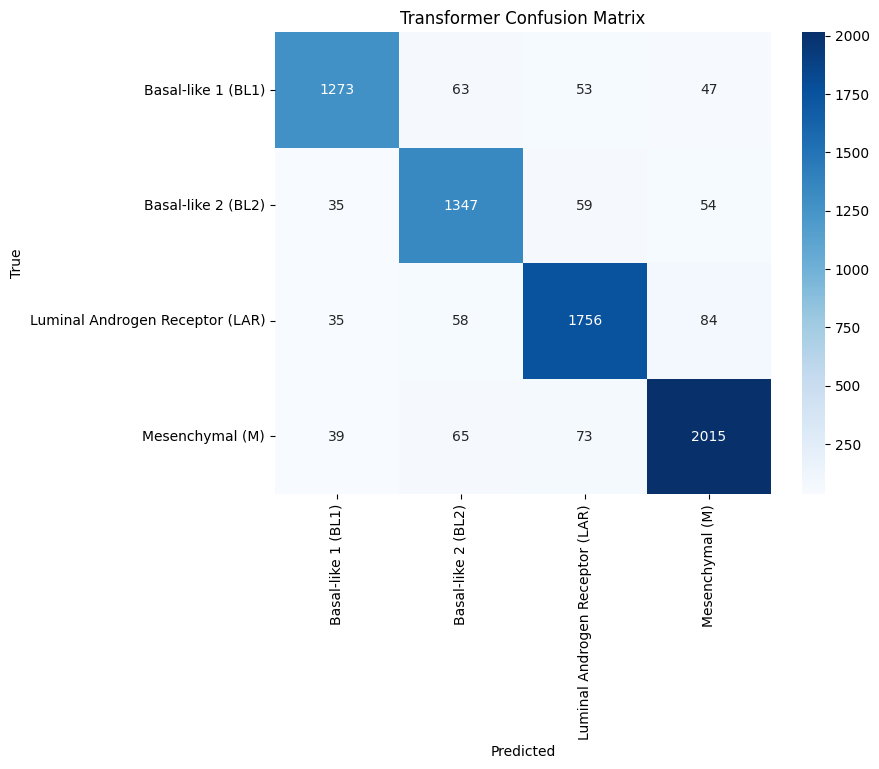


Matthews Correlation Coefficient (MCC): 0.873
Epoch 0 - Loss: 0.1800, Accuracy: 0.9329
Epoch 10 - Loss: 0.1627, Accuracy: 0.9388
Epoch 20 - Loss: 0.1426, Accuracy: 0.9473
Epoch 30 - Loss: 0.1264, Accuracy: 0.9531
Epoch 40 - Loss: 0.1145, Accuracy: 0.9571
Epoch 50 - Loss: 0.1130, Accuracy: 0.9570
Epoch 60 - Loss: 0.0964, Accuracy: 0.9654
Epoch 70 - Loss: 0.0808, Accuracy: 0.9716
Epoch 80 - Loss: 0.0743, Accuracy: 0.9733
Epoch 90 - Loss: 0.0666, Accuracy: 0.9775
Epoch 99 - Loss: 0.0640, Accuracy: 0.9769


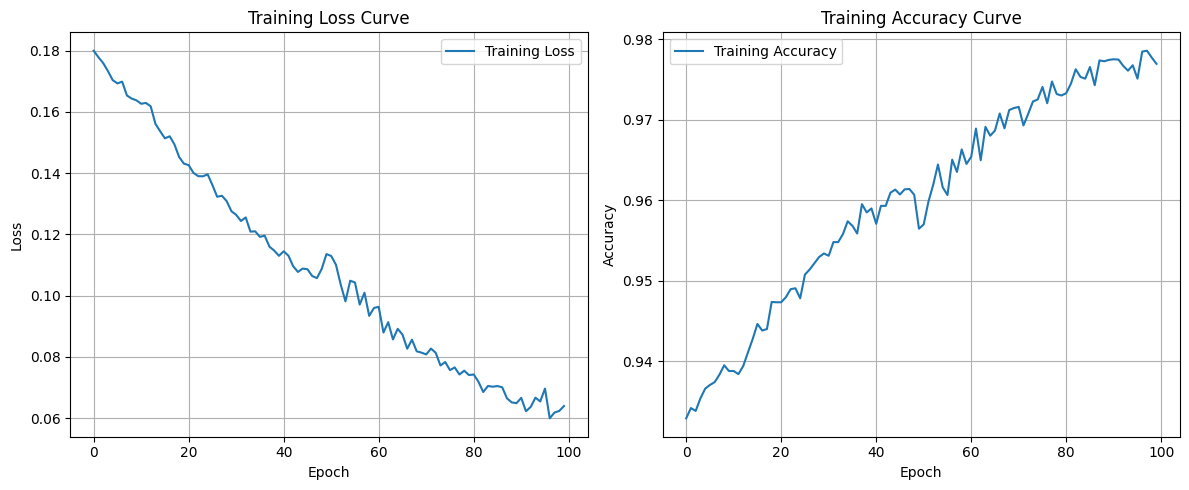

In [ ]:
# --- Evaluate the model ---
model.eval()
with torch.no_grad():
    train_logits = model(X_train_tensor)
    test_logits = model(X_test_tensor)

    train_preds = train_logits.argmax(dim=1).numpy()
    test_preds = test_logits.argmax(dim=1).numpy()

    train_probs = torch.softmax(train_logits, dim=1).numpy()
    test_probs = torch.softmax(test_logits, dim=1).numpy()

# --- Accuracy ---
print("\nTrain Accuracy:", accuracy_score(y_train_tensor.numpy(), train_preds))
print("Test Accuracy:", accuracy_score(y_test_tensor.numpy(), test_preds))

# --- F1, Precision, Recall ---
print("\nMacro Precision:", precision_score(y_test_tensor, test_preds, average='macro'))
print("Macro Recall:", recall_score(y_test_tensor, test_preds, average='macro'))
print("Macro F1 Score:", f1_score(y_test_tensor, test_preds, average='macro'))

print("\nWeighted Precision:", precision_score(y_test_tensor, test_preds, average='weighted'))
print("Weighted Recall:", recall_score(y_test_tensor, test_preds, average='weighted'))
print("Weighted F1 Score:", f1_score(y_test_tensor, test_preds, average='weighted'))

# --- ROC AUC ---
y_test_binarized = label_binarize(y_test_tensor.numpy(), classes=np.unique(y))
roc_auc = roc_auc_score(y_test_binarized, test_probs, average='macro', multi_class='ovr')
print("\nROC AUC Score (OvR, macro):", round(roc_auc, 4))

# --- Classification Report ---
print("\nClassification Report:")
print(classification_report(y_test_tensor, test_preds, target_names=label_encoder.classes_))

# --- Confusion Matrix ---
cm = confusion_matrix(y_test_tensor, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Transformer Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# --- MCC ---
mcc = matthews_corrcoef(y_test_tensor, test_preds)
print("\nMatthews Correlation Coefficient (MCC):", round(mcc, 4))

# --- Training Loss + Accuracy Tracking ---
train_losses = []
train_accuracies = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    preds = outputs.argmax(dim=1)
    acc = (preds == y_train_tensor).float().mean().item()

    train_losses.append(loss.item())
    train_accuracies.append(acc)

    if epoch % 10 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch} - Loss: {loss.item():.4f}, Accuracy: {acc:.4f}")

# --- Plot Training Loss & Accuracy ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Curve")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:

# Ensure the model is in evaluation mode
model.eval()

# Sample a small background dataset for SHAP
background = X_train_tensor[:100]  # Keep it small for performance

# Use GradientExplainer directly with the model (no wrapper function)
explainer = shap.GradientExplainer(model, background)

# Compute SHAP values for test data
shap_values = explainer.shap_values(X_test_tensor)

# Convert to NumPy for plotting
X_test_np = X_test_tensor.numpy()


SHAP shape after transpose: (4, 7056, 69)

--- SHAP Summary for Subtype: Basal-like 1 (BL1) ---


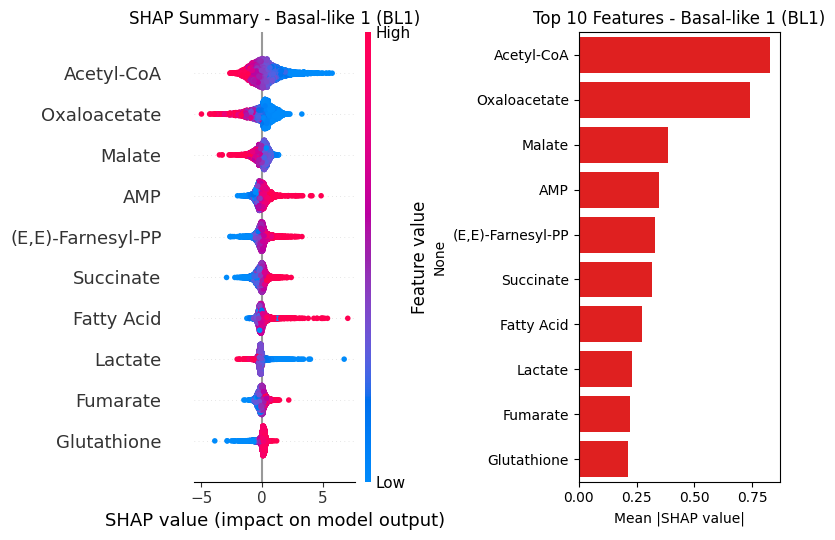


--- SHAP Summary for Subtype: Basal-like 2 (BL2) ---


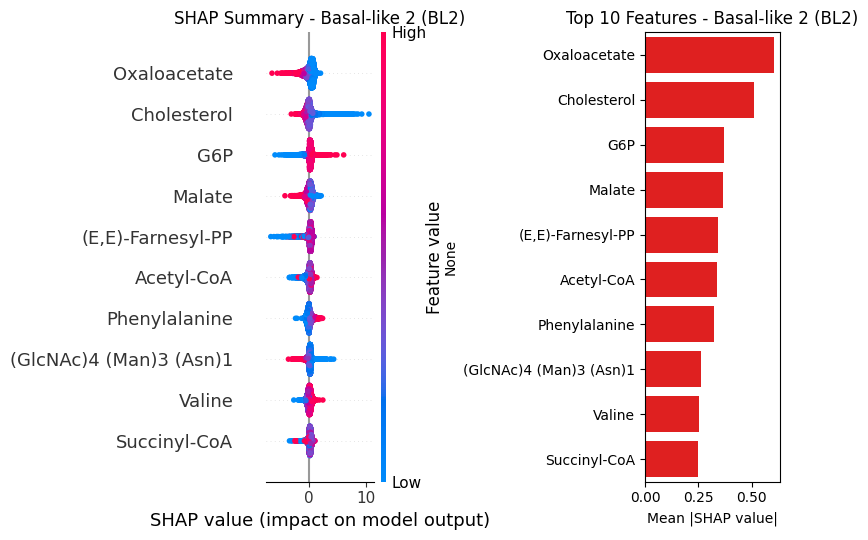


--- SHAP Summary for Subtype: Luminal Androgen Receptor (LAR) ---


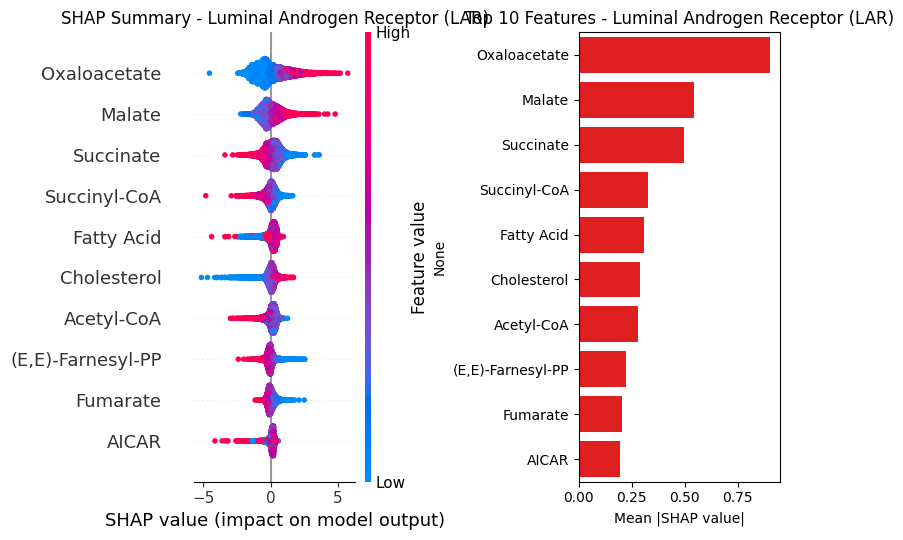


--- SHAP Summary for Subtype: Mesenchymal (M) ---


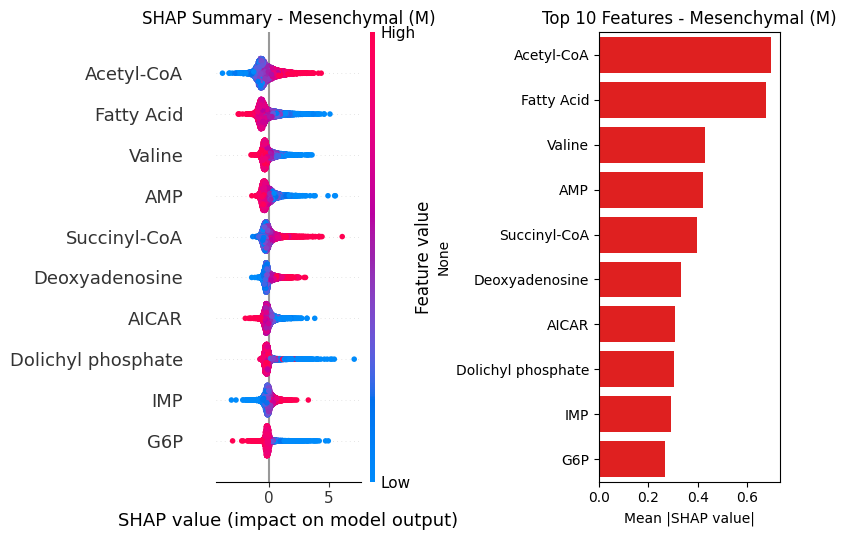

In [ ]:

# Transpose: (samples, features, classes) -> (classes, samples, features)
shap_values = np.transpose(shap_values, (2, 0, 1))  # Now shape = (4, 7056, 69)

print("SHAP shape after transpose:", shap_values.shape)

# Loop over each class
for i, subtype in enumerate(label_encoder.classes_):
    print(f"\n--- SHAP Summary for Subtype: {subtype} ---")

    # Compute the mean absolute SHAP value for ranking the features
    mean_shap = np.mean(np.abs(shap_values[i]), axis=0)

    # Get indices for the top 10 features
    top_indices = np.argsort(mean_shap)[-10:][::-1]

    # Filter SHAP values and features for top 10
    shap_values_top = shap_values[i][:, top_indices]
    X_test_top = X_test_np[:, top_indices]
    top_feature_names = feature_names[top_indices]

    plt.figure(figsize=(14, 6))

    # SHAP Summary Plot for top 10 features (left)
    plt.subplot(1, 2, 1)
    shap.summary_plot(shap_values_top, X_test_top, feature_names=top_feature_names, plot_type='dot', show=False)
    plt.title(f"SHAP Summary - {subtype}")

    # Red bar plot of top 10 features (right)
    plt.subplot(1, 2, 2)
    top_importances = mean_shap[top_indices]
    sns.barplot(x=top_importances, y=top_feature_names, color='red')
    plt.title(f"Top 10 Features - {subtype}")
    plt.xlabel("Mean |SHAP value|")

    plt.tight_layout()
    plt.show()


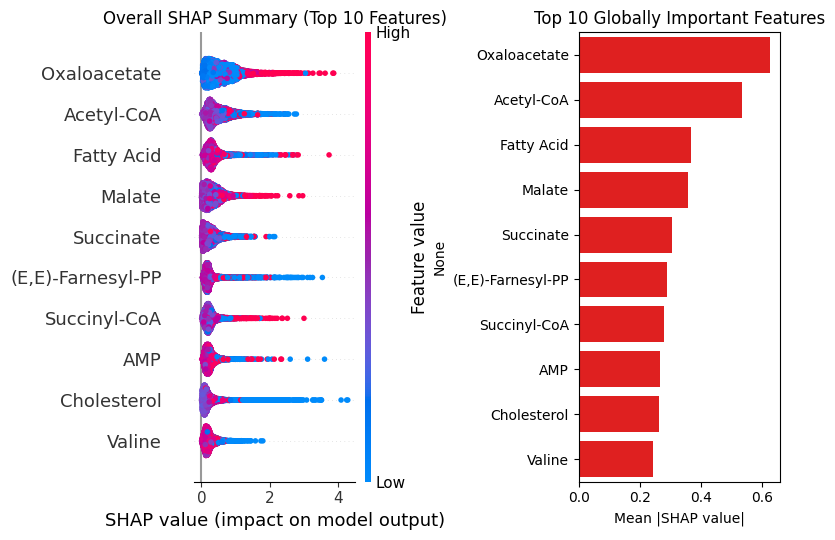

In [ ]:
# SHAP values shape: (classes, samples, features) — assumed already transposed
# Combine SHAP values across classes: take mean of absolute values across classes
global_shap = np.mean(np.abs(shap_values), axis=0)  # shape: (samples, features)

# Compute global mean SHAP importance per feature
global_mean_shap = np.mean(global_shap, axis=0)

# Get indices of top 10 most important features
top_indices = np.argsort(global_mean_shap)[-10:][::-1]
top_features = feature_names[top_indices]
top_importances = global_mean_shap[top_indices]

# Filter SHAP values and features for top 10
shap_values_top = global_shap[:, top_indices]
X_test_top = X_test_np[:, top_indices]
top_feature_names = feature_names[top_indices]

plt.figure(figsize=(14, 6))

# Overall SHAP summary plot (left)
plt.subplot(1, 2, 1)
shap.summary_plot(shap_values_top, X_test_top, feature_names=top_feature_names, plot_type='dot', show=False)
plt.title("Overall SHAP Summary (Top 10 Features)")

# Global feature importance bar plot (right)
plt.subplot(1, 2, 2)
sns.barplot(x=top_importances, y=top_features, color='red')
plt.title("Top 10 Globally Important Features")
plt.xlabel("Mean |SHAP value|")

plt.tight_layout()
plt.show()

###====================== USING UMAP DATAFRAME =======================

In [1]:
# === Core Libraries ===
import numpy as np
import pandas as pd

# === PyTorch: Deep Learning ===
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    matthews_corrcoef,
    roc_auc_score,
    roc_curve,
    f1_score,
    precision_score,
    recall_score
)
import matplotlib.pyplot as plt
import seaborn as sns
# === Sklearn: Preprocessing & Metrics ===
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    matthews_corrcoef
)
from sklearn.model_selection import train_test_split

# === Visualization ===
import matplotlib.pyplot as plt
import seaborn as sns

# === SHAP for Explainability ===
import shap

# === (Optional) Warnings Suppression ===
import warnings
warnings.filterwarnings('ignore')


Epoch 0 - Loss: 1.5361, Accuracy: 0.2385
Epoch 10 - Loss: 0.5125, Accuracy: 0.8063
Epoch 20 - Loss: 0.4206, Accuracy: 0.8379
Epoch 30 - Loss: 0.3650, Accuracy: 0.8590
Epoch 40 - Loss: 0.3260, Accuracy: 0.8738
Epoch 50 - Loss: 0.2946, Accuracy: 0.8856
Epoch 60 - Loss: 0.2675, Accuracy: 0.8958
Epoch 70 - Loss: 0.2422, Accuracy: 0.9068
Epoch 80 - Loss: 0.2194, Accuracy: 0.9158
Epoch 90 - Loss: 0.1977, Accuracy: 0.9262
Epoch 99 - Loss: 0.1778, Accuracy: 0.9330

Train Accuracy: 0.9460311835577605
Test Accuracy: 0.9068877551020408

Classification Report (Test):
                                 precision    recall  f1-score   support

             Basal-like 1 (BL1)       0.92      0.89      0.90      1436
             Basal-like 2 (BL2)       0.88      0.91      0.89      1495
Luminal Androgen Receptor (LAR)       0.90      0.92      0.91      1933
                Mesenchymal (M)       0.93      0.91      0.92      2192

                       accuracy                           0.91      705

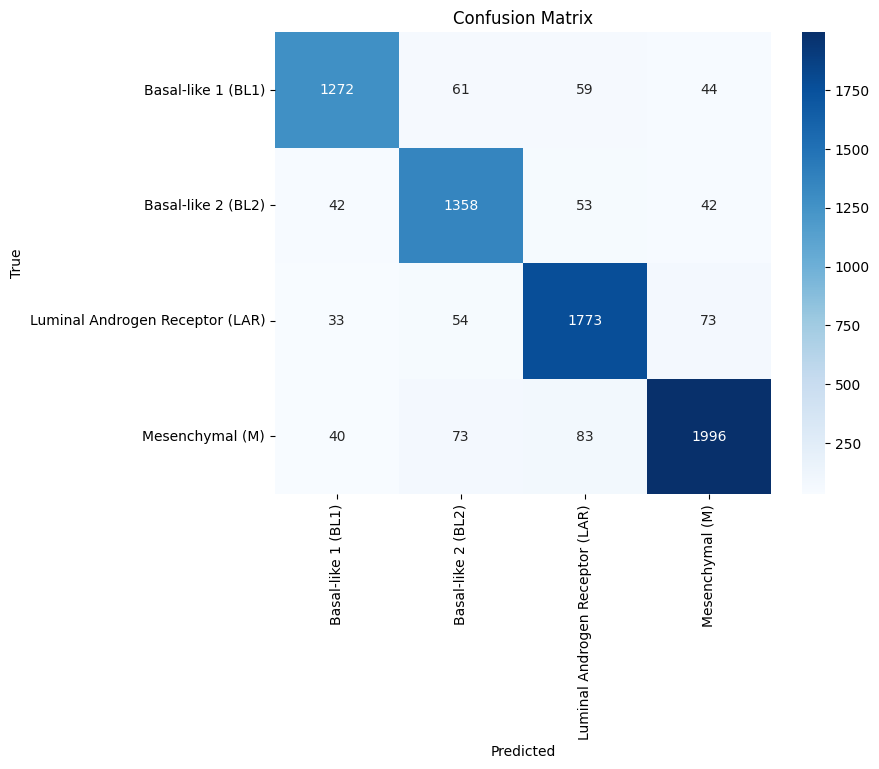


Matthews Correlation Coefficient (MCC): 0.8746


In [ ]:


label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['TNBC_Subtype'])
X = df.drop(columns=['TNBC_Subtype']).values
feature_names = df.drop(columns=['TNBC_Subtype']).columns

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# -------------------------
# Transformer Model
# -------------------------
class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dim, num_heads, num_layers, dropout):
        super(TransformerModel, self).__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.input_layer(x).unsqueeze(1)
        x = self.transformer(x)
        x = x[:, 0, :]
        return self.classifier(x)

# Hyperparameters
input_dim = X.shape[1]
hidden_dim = 128
num_heads = 4
num_layers = 2
dropout = 0.1
num_classes = len(np.unique(y))
learning_rate = 0.0005
epochs = 100

model = TransformerModel(input_dim, num_classes, hidden_dim, num_heads, num_layers, dropout)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# -------------------------
# Training Loop
# -------------------------
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    preds = outputs.argmax(dim=1)
    acc = (preds == y_train_tensor).float().mean().item()

    if epoch % 10 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch} - Loss: {loss.item():.4f}, Accuracy: {acc:.4f}")

# Evaluate
model.eval()
with torch.no_grad():
    train_preds = model(X_train_tensor).argmax(dim=1)
    test_preds = model(X_test_tensor).argmax(dim=1)

print("\nTrain Accuracy:", accuracy_score(y_train_tensor.numpy(), train_preds.numpy()))
print("Test Accuracy:", accuracy_score(y_test_tensor.numpy(), test_preds.numpy()))

print("\nClassification Report (Test):")
print(classification_report(y_test_tensor.numpy(), test_preds.numpy(), target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test_tensor.numpy(), test_preds.numpy())
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# MCC
mcc = matthews_corrcoef(y_test_tensor.numpy(), test_preds.numpy())
print("\nMatthews Correlation Coefficient (MCC):", round(mcc, 4))



In [ ]:
import shap
import torch

# Ensure the model is in evaluation mode
model.eval()

# Sample a small background dataset for SHAP
background = X_train_tensor[:100]  # Keep it small for performance

# Use GradientExplainer directly with the model (no wrapper function)
explainer = shap.GradientExplainer(model, background)

# Compute SHAP values for test data
shap_values = explainer.shap_values(X_test_tensor)

# Convert to NumPy for plotting
X_test_np = X_test_tensor.numpy()


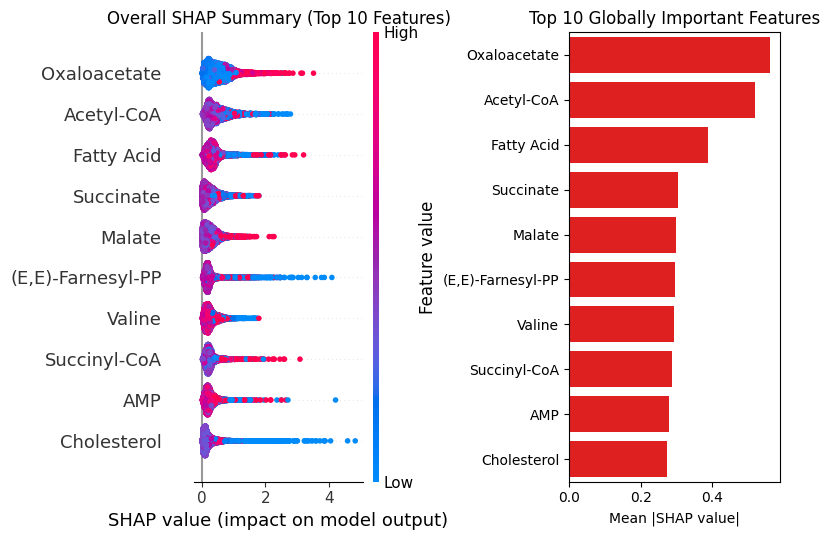

In [ ]:
# SHAP values shape: (classes, samples, features) — assumed already transposed
# Combine SHAP values across classes: take mean of absolute values across classes
global_shap = np.mean(np.abs(shap_values), axis=0)  # shape: (samples, features)

# Compute global mean SHAP importance per feature
global_mean_shap = np.mean(global_shap, axis=0)

# Get indices of top 10 most important features
top_indices = np.argsort(global_mean_shap)[-10:][::-1]
top_features = feature_names[top_indices]
top_importances = global_mean_shap[top_indices]

# Filter SHAP values and features for top 10
shap_values_top = global_shap[:, top_indices]
X_test_top = X_test_np[:, top_indices]
top_feature_names = feature_names[top_indices]

plt.figure(figsize=(14, 6))

# Overall SHAP summary plot (left)
plt.subplot(1, 2, 1)
shap.summary_plot(shap_values_top, X_test_top, feature_names=top_feature_names, plot_type='dot', show=False)
plt.title("Overall SHAP Summary (Top 10 Features)")

# Global feature importance bar plot (right)
plt.subplot(1, 2, 2)
sns.barplot(x=top_importances, y=top_features, color='red')
plt.title("Top 10 Globally Important Features")
plt.xlabel("Mean |SHAP value|")

plt.tight_layout()
plt.show()

SHAP shape after transpose: (4, 7056, 69)

--- SHAP Summary for Subtype: Basal-like 1 (BL1) ---


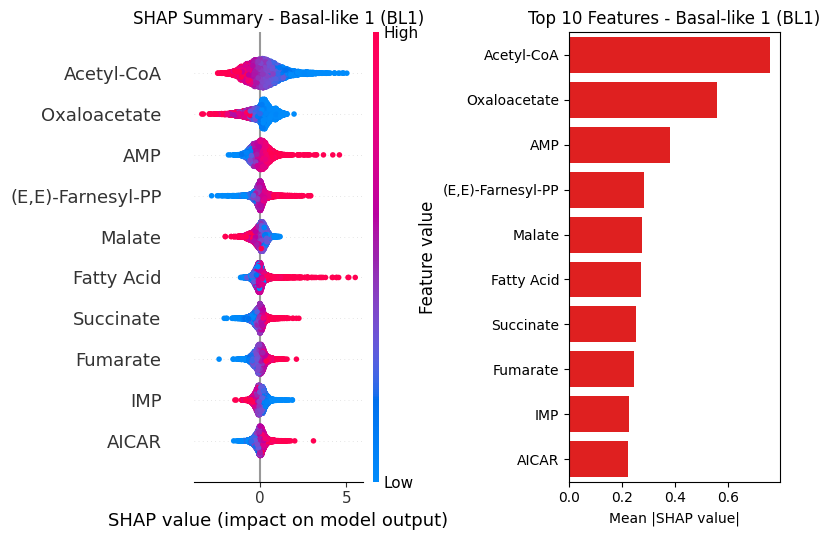


--- SHAP Summary for Subtype: Basal-like 2 (BL2) ---


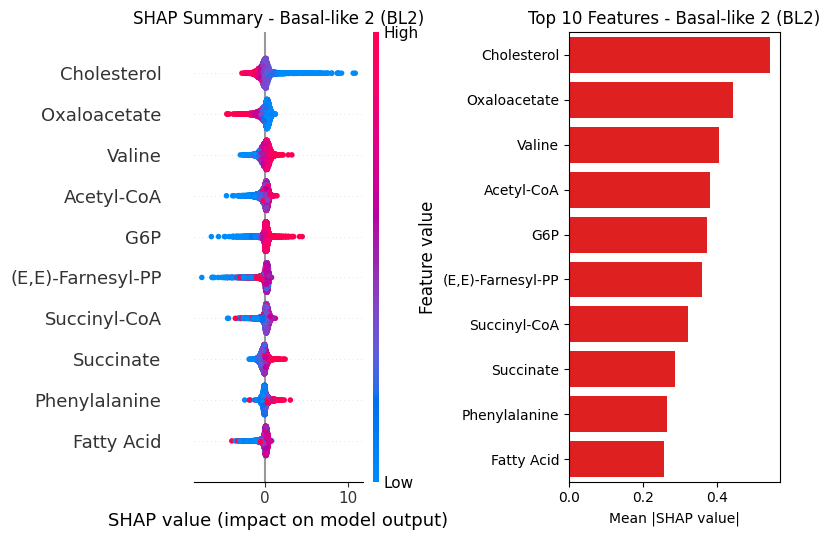


--- SHAP Summary for Subtype: Luminal Androgen Receptor (LAR) ---


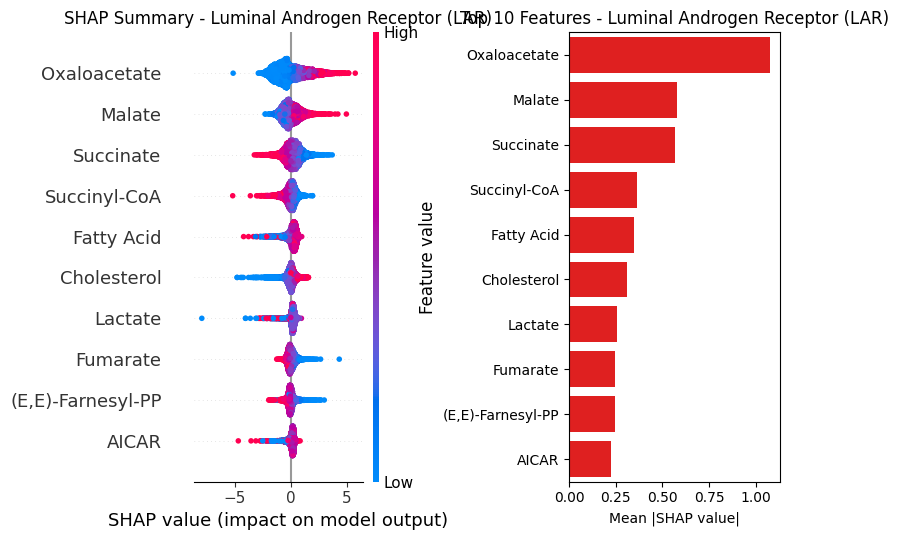


--- SHAP Summary for Subtype: Mesenchymal (M) ---


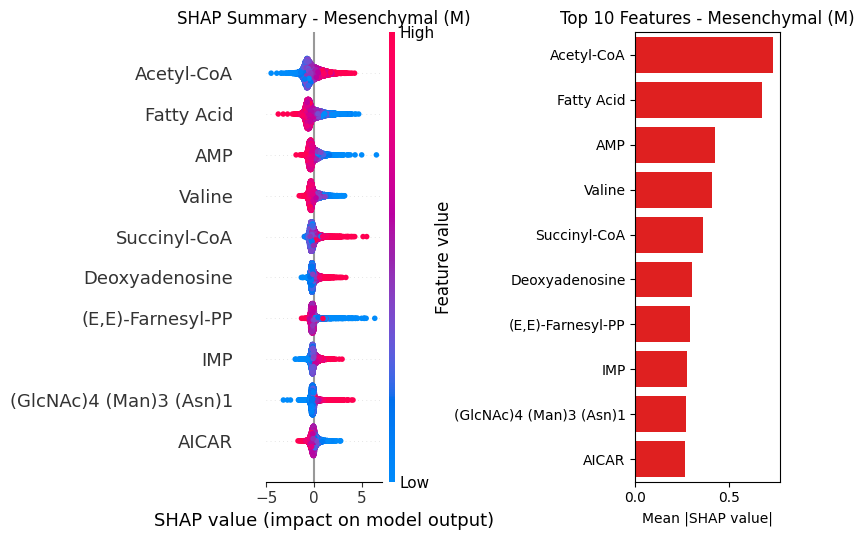

In [ ]:

# Transpose: (samples, features, classes) -> (classes, samples, features)
shap_values = np.transpose(shap_values, (2, 0, 1))  # Now shape = (4, 7056, 69)

print("SHAP shape after transpose:", shap_values.shape)

# Loop over each class
for i, subtype in enumerate(label_encoder.classes_):
    print(f"\n--- SHAP Summary for Subtype: {subtype} ---")

    # Compute the mean absolute SHAP value for ranking the features
    mean_shap = np.mean(np.abs(shap_values[i]), axis=0)

    # Get indices for the top 10 features
    top_indices = np.argsort(mean_shap)[-10:][::-1]

    # Filter SHAP values and features for top 10
    shap_values_top = shap_values[i][:, top_indices]
    X_test_top = X_test_np[:, top_indices]
    top_feature_names = feature_names[top_indices]

    plt.figure(figsize=(14, 6))

    # SHAP Summary Plot for top 10 features (left)
    plt.subplot(1, 2, 1)
    shap.summary_plot(shap_values_top, X_test_top, feature_names=top_feature_names, plot_type='dot', show=False)
    plt.title(f"SHAP Summary - {subtype}")

    # Red bar plot of top 10 features (right)
    plt.subplot(1, 2, 2)
    top_importances = mean_shap[top_indices]
    sns.barplot(x=top_importances, y=top_feature_names, color='red')
    plt.title(f"Top 10 Features - {subtype}")
    plt.xlabel("Mean |SHAP value|")

    plt.tight_layout()
    plt.show()


SHAP shape after transpose: (4, 7056, 69)

--- SHAP Summary for Subtype: Basal-like 1 (BL1) ---


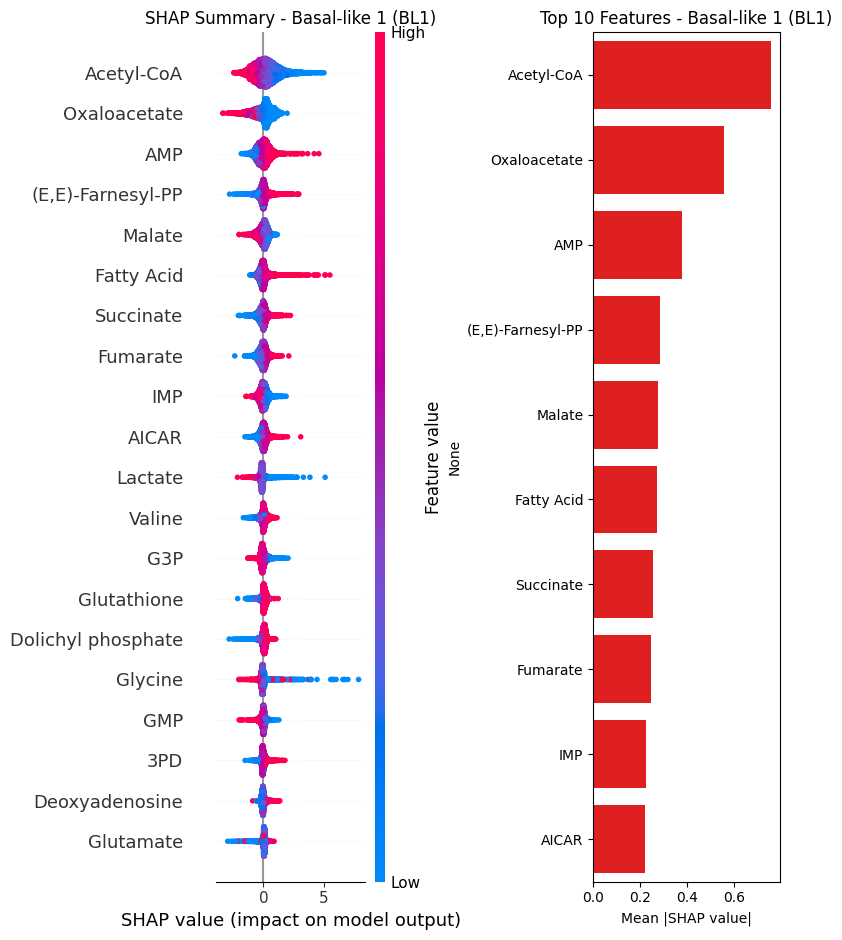


--- SHAP Summary for Subtype: Basal-like 2 (BL2) ---


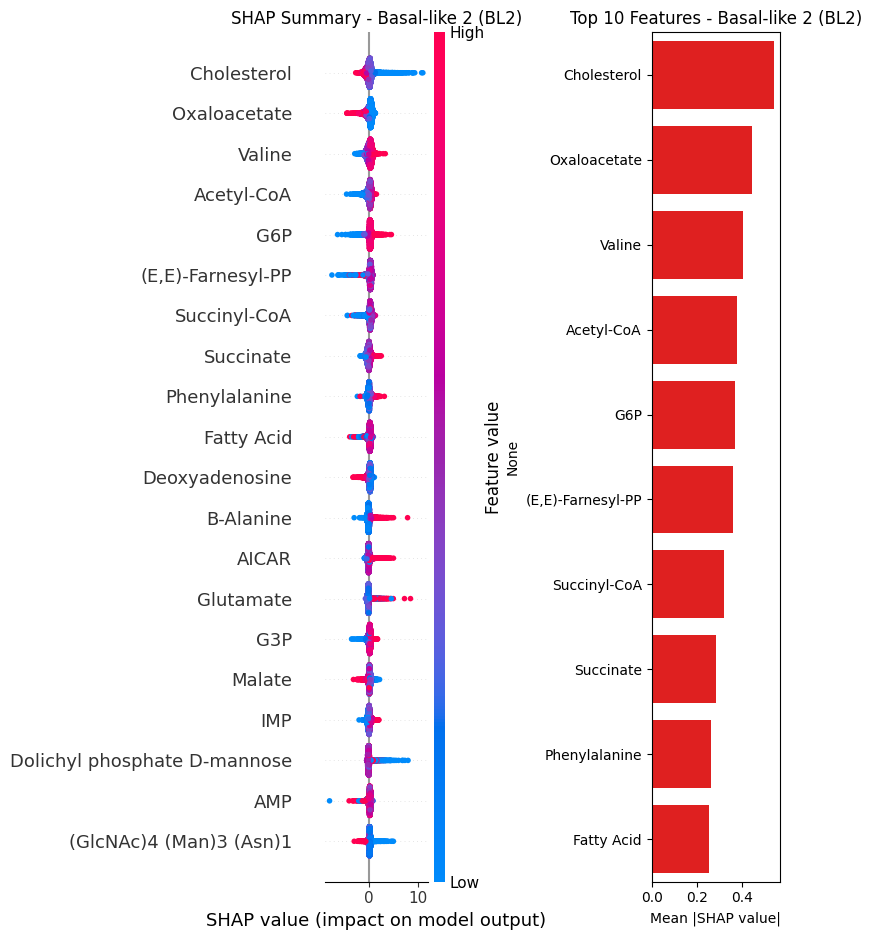


--- SHAP Summary for Subtype: Luminal Androgen Receptor (LAR) ---


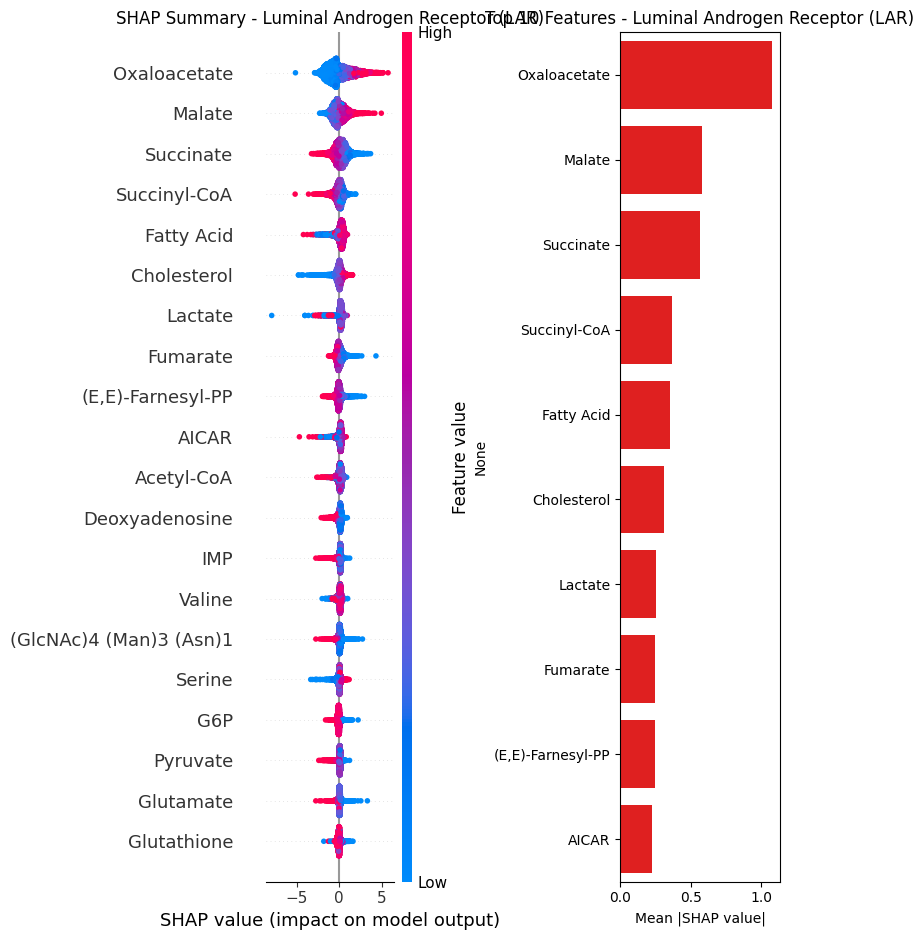


--- SHAP Summary for Subtype: Mesenchymal (M) ---


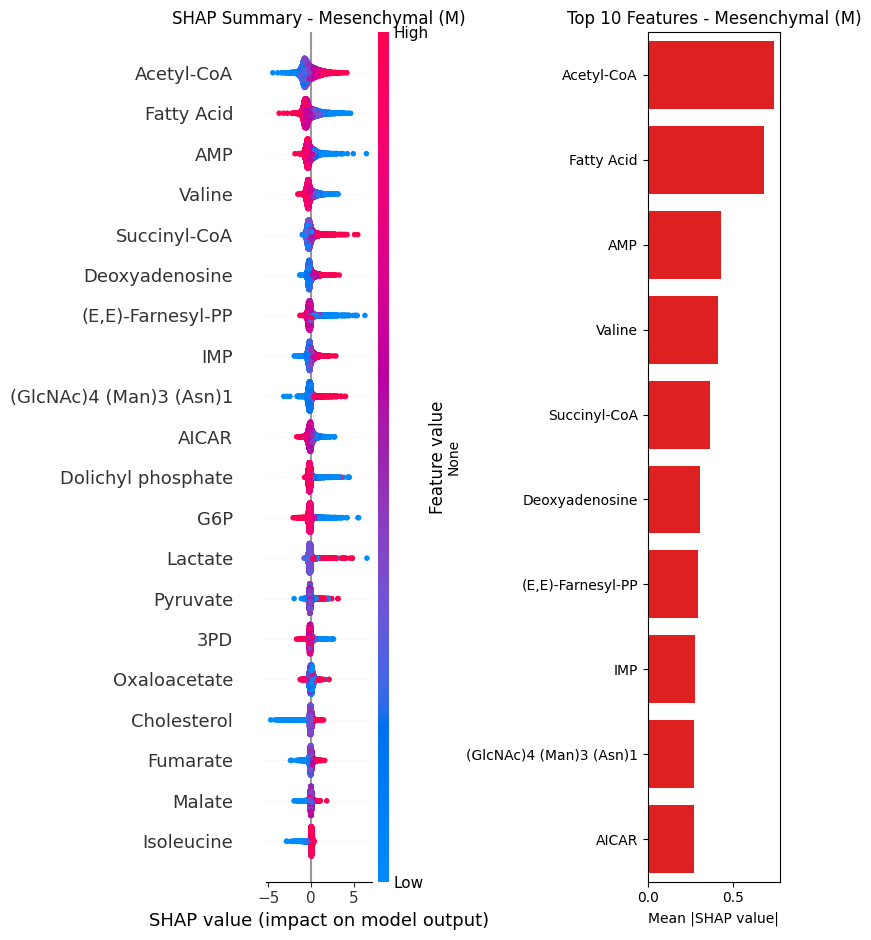

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Transpose: (samples, features, classes) -> (classes, samples, features)
shap_values = np.transpose(shap_values, (2, 0, 1))  # Now shape = (4, 7056, 69)

print("SHAP shape after transpose:", shap_values.shape)

# Loop over each class
for i, subtype in enumerate(label_encoder.classes_):
    print(f"\n--- SHAP Summary for Subtype: {subtype} ---")

    plt.figure(figsize=(14, 6))

    # SHAP Summary Plot (left)
    plt.subplot(1, 2, 1)
    shap.summary_plot(shap_values[i], X_test_np, feature_names=feature_names, plot_type='dot', show=False)
    plt.title(f"SHAP Summary - {subtype}")

    # Red bar plot of top 10 features (right)
    plt.subplot(1, 2, 2)
    mean_shap = np.mean(np.abs(shap_values[i]), axis=0)
    top_indices = np.argsort(mean_shap)[-10:][::-1]
    top_features = feature_names[top_indices]
    top_importances = mean_shap[top_indices]
    sns.barplot(x=top_importances, y=top_features, color='red')
    plt.title(f"Top 10 Features - {subtype}")
    plt.xlabel("Mean |SHAP value|")

    plt.tight_layout()
    plt.show()


Epoch 0 - Loss: 1.5585, Accuracy: 0.2348
Epoch 10 - Loss: 0.5229, Accuracy: 0.8030
Epoch 20 - Loss: 0.4130, Accuracy: 0.8434
Epoch 30 - Loss: 0.3639, Accuracy: 0.8598
Epoch 40 - Loss: 0.3237, Accuracy: 0.8735
Epoch 50 - Loss: 0.2906, Accuracy: 0.8888
Epoch 60 - Loss: 0.2640, Accuracy: 0.8986
Epoch 70 - Loss: 0.2380, Accuracy: 0.9100
Epoch 80 - Loss: 0.2182, Accuracy: 0.9162
Epoch 90 - Loss: 0.1963, Accuracy: 0.9241
Epoch 99 - Loss: 0.1763, Accuracy: 0.9335

Train Accuracy: 0.9457122608079377
Test Accuracy: 0.9066043083900227

Classification Report (Test):
                                 precision    recall  f1-score   support

             Basal-like 1 (BL1)       0.91      0.90      0.90      1436
             Basal-like 2 (BL2)       0.90      0.90      0.90      1495
Luminal Androgen Receptor (LAR)       0.91      0.90      0.91      1933
                Mesenchymal (M)       0.91      0.92      0.91      2192

                       accuracy                           0.91      705

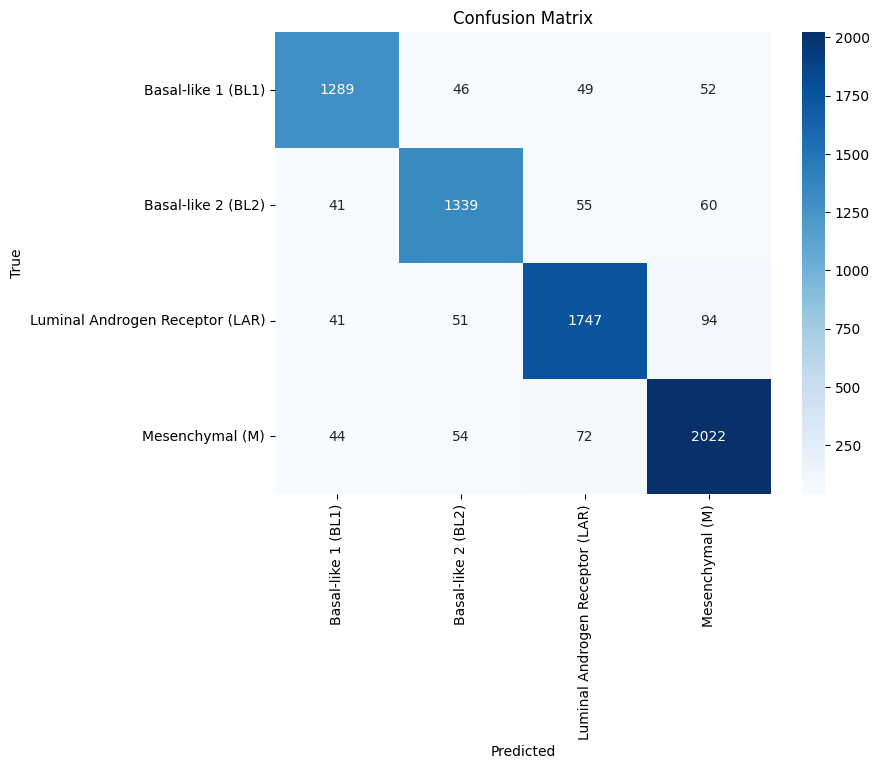


Matthews Correlation Coefficient (MCC): 0.8741


In [ ]:


label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['TNBC_Subtype'])
X = df.drop(columns=['TNBC_Subtype']).values
feature_names = df.drop(columns=['TNBC_Subtype']).columns

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# -------------------------
# Transformer Model
# -------------------------
class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dim, num_heads, num_layers, dropout):
        super(TransformerModel, self).__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.input_layer(x).unsqueeze(1)
        x = self.transformer(x)
        x = x[:, 0, :]
        return self.classifier(x)

# Hyperparameters
input_dim = X.shape[1]
hidden_dim = 128
num_heads = 4
num_layers = 2
dropout = 0.1
num_classes = len(np.unique(y))
learning_rate = 0.0005
epochs = 100

model = TransformerModel(input_dim, num_classes, hidden_dim, num_heads, num_layers, dropout)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# -------------------------
# Training Loop
# -------------------------
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    preds = outputs.argmax(dim=1)
    acc = (preds == y_train_tensor).float().mean().item()

    if epoch % 10 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch} - Loss: {loss.item():.4f}, Accuracy: {acc:.4f}")

# Evaluate
model.eval()
with torch.no_grad():
    train_preds = model(X_train_tensor).argmax(dim=1)
    test_preds = model(X_test_tensor).argmax(dim=1)

print("\nTrain Accuracy:", accuracy_score(y_train_tensor.numpy(), train_preds.numpy()))
print("Test Accuracy:", accuracy_score(y_test_tensor.numpy(), test_preds.numpy()))

print("\nClassification Report (Test):")
print(classification_report(y_test_tensor.numpy(), test_preds.numpy(), target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test_tensor.numpy(), test_preds.numpy())
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# MCC
mcc = matthews_corrcoef(y_test_tensor.numpy(), test_preds.numpy())
print("\nMatthews Correlation Coefficient (MCC):", round(mcc, 4))



PermutationExplainer explainer: 7057it [3:38:36,  1.86s/it]


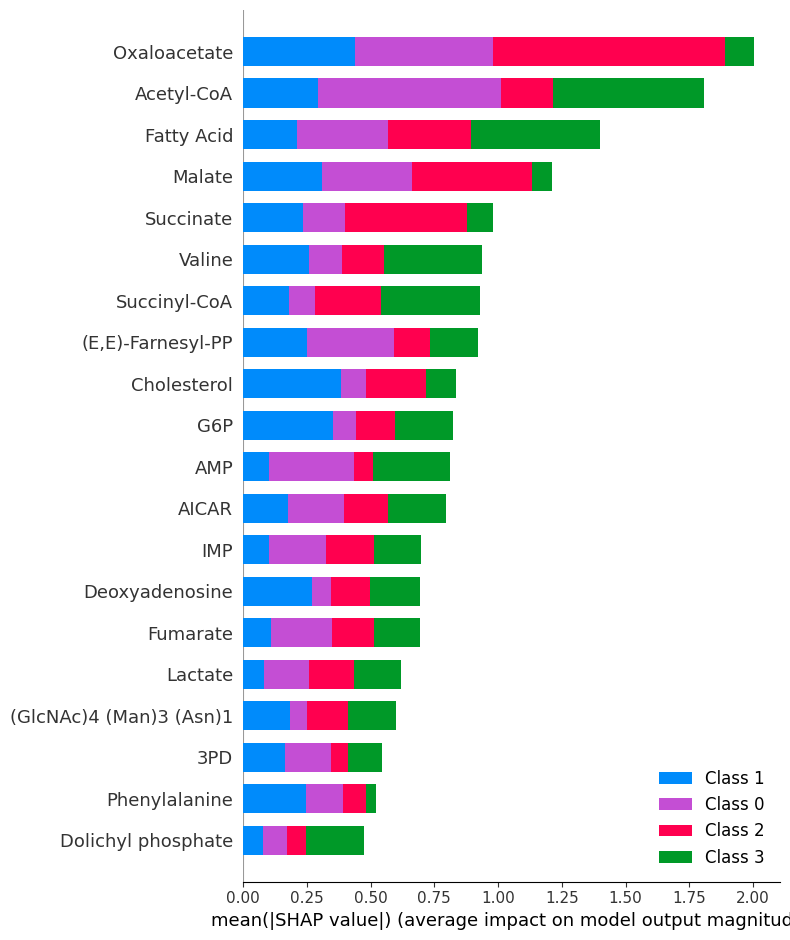

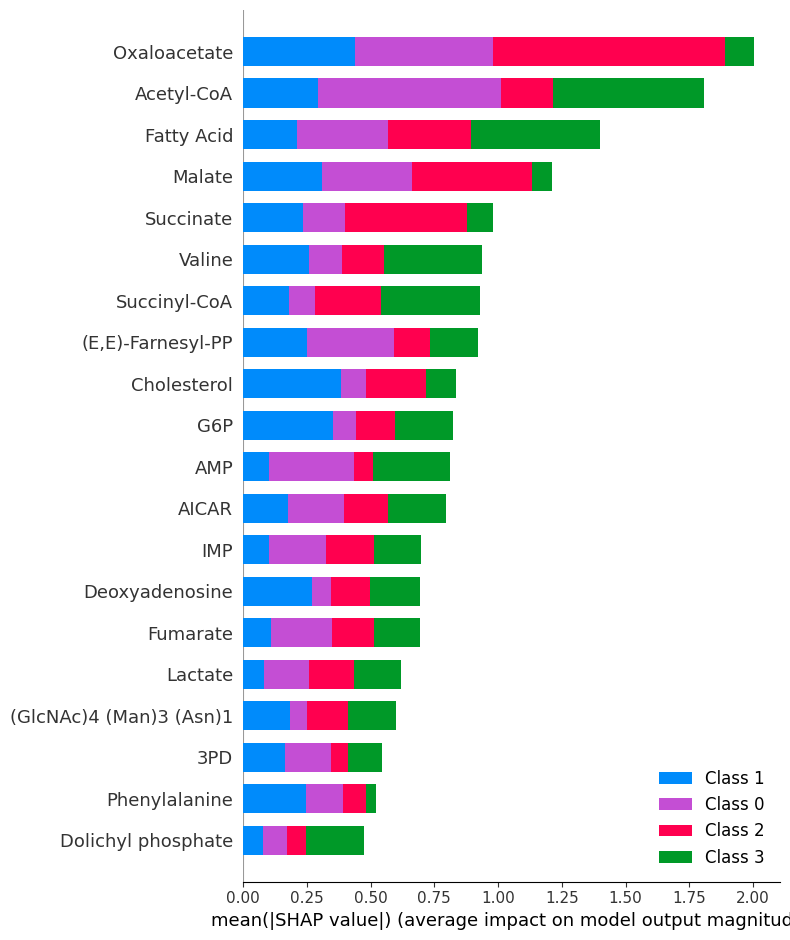


SHAP for Subtype: Basal-like 1 (BL1)


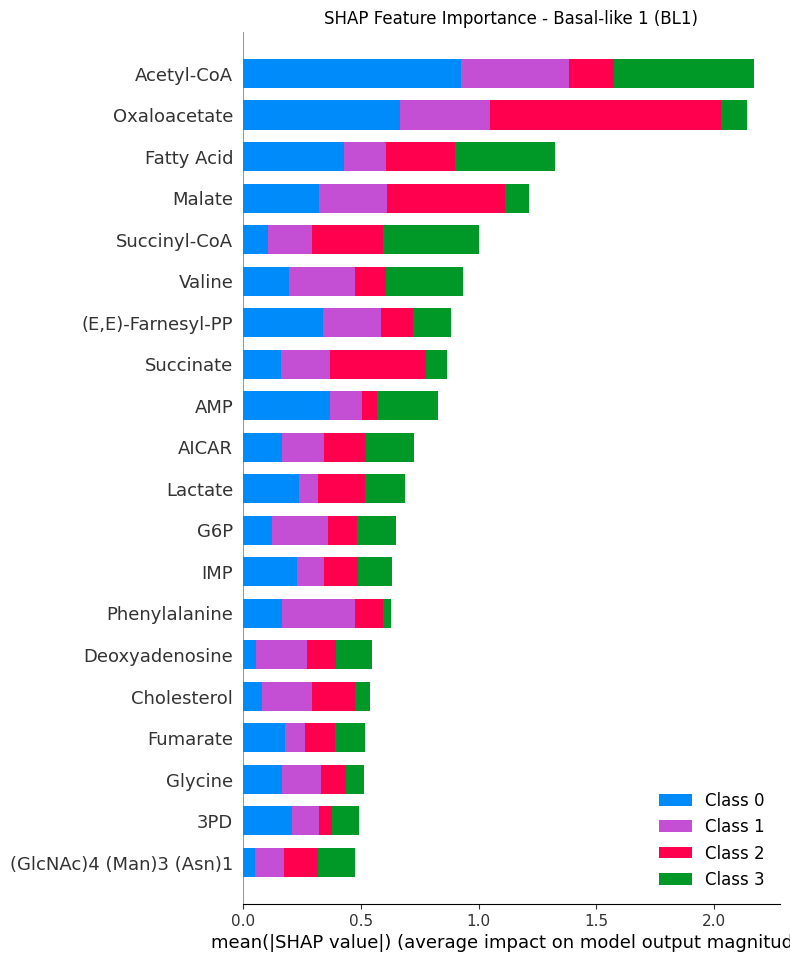

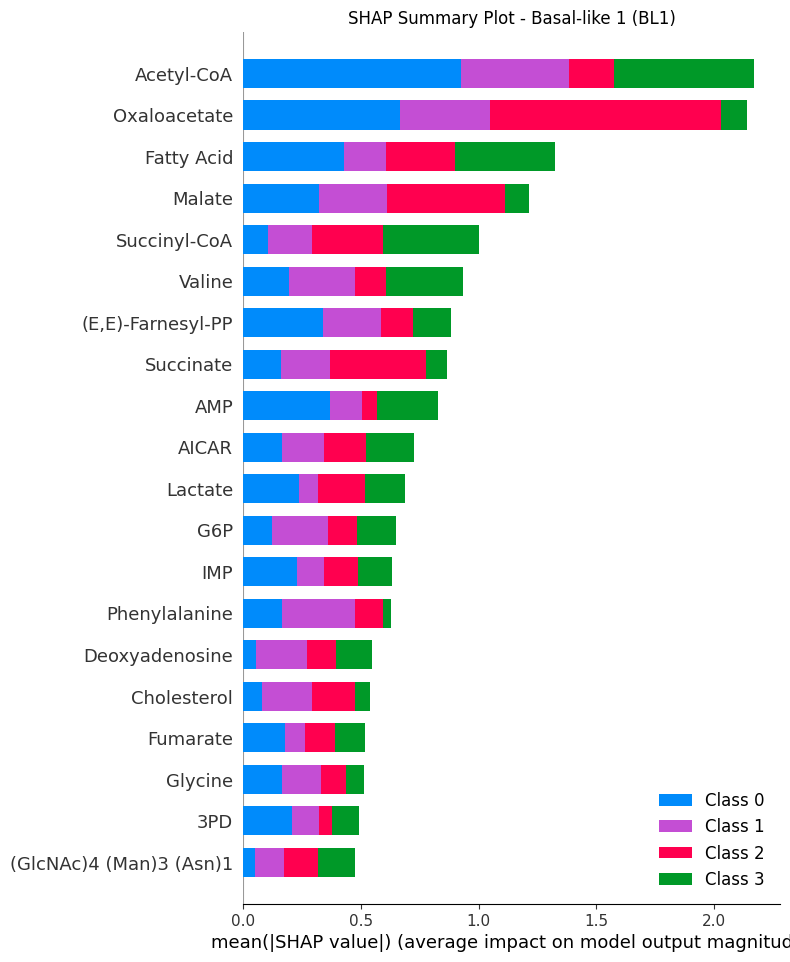


SHAP for Subtype: Basal-like 2 (BL2)


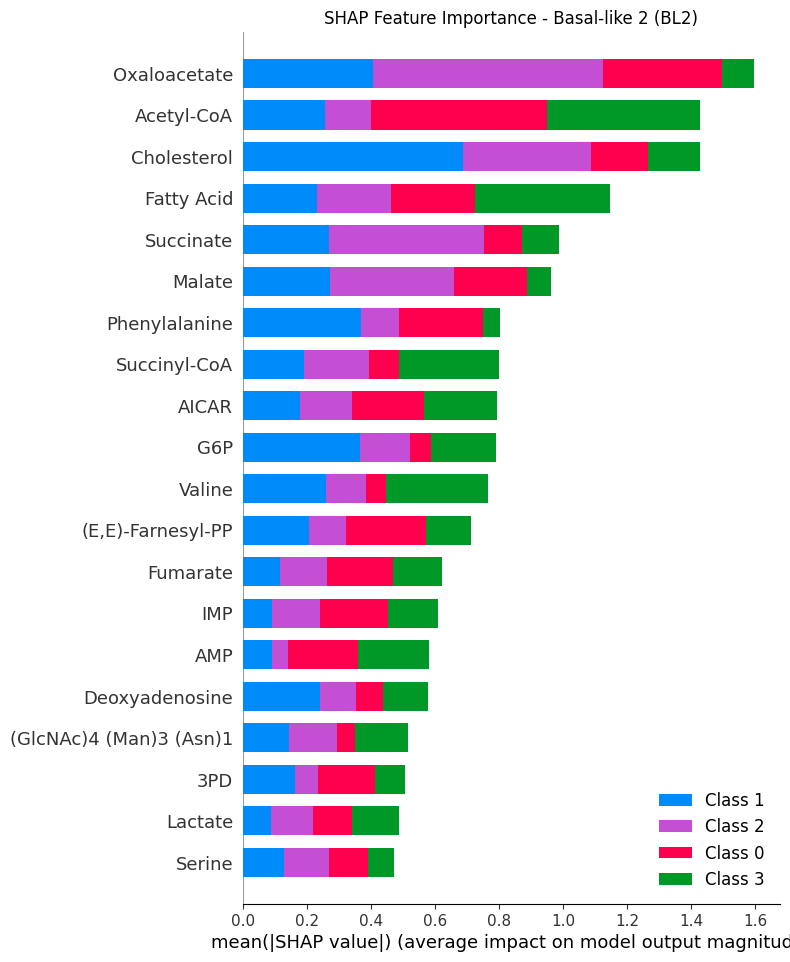

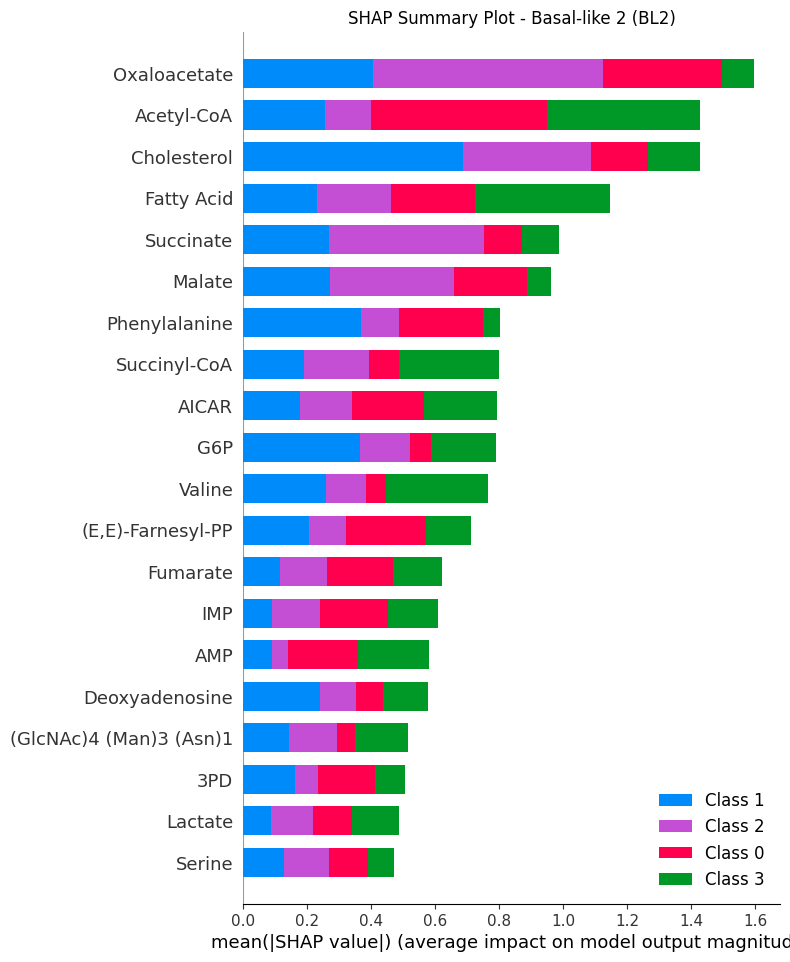


SHAP for Subtype: Luminal Androgen Receptor (LAR)


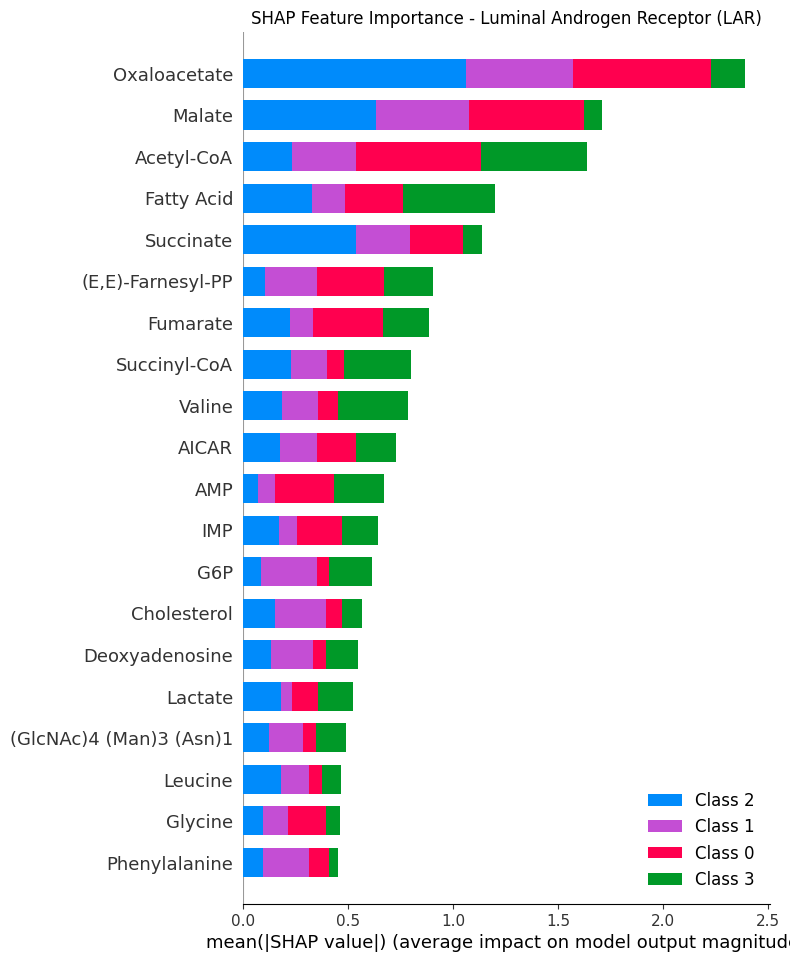

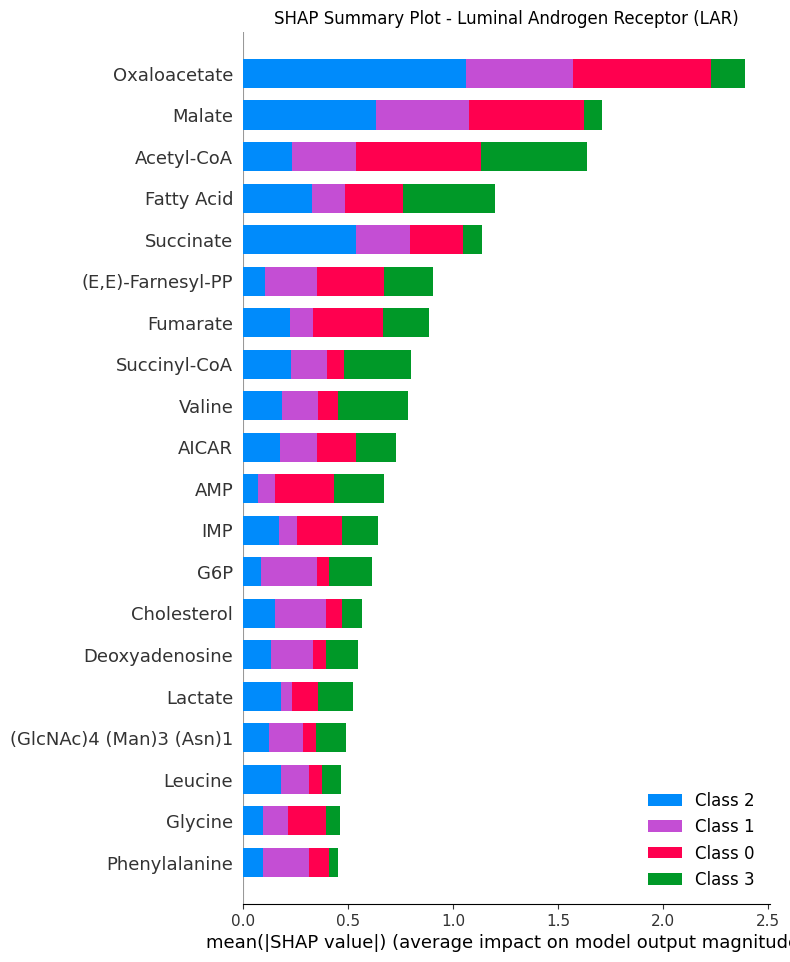


SHAP for Subtype: Mesenchymal (M)


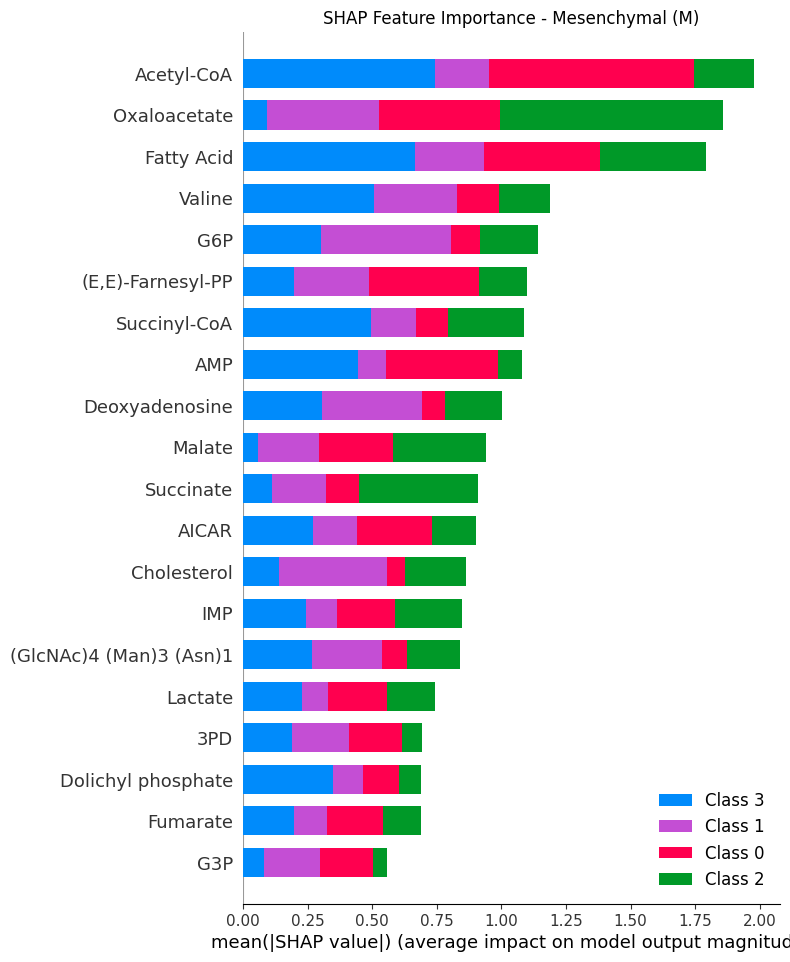

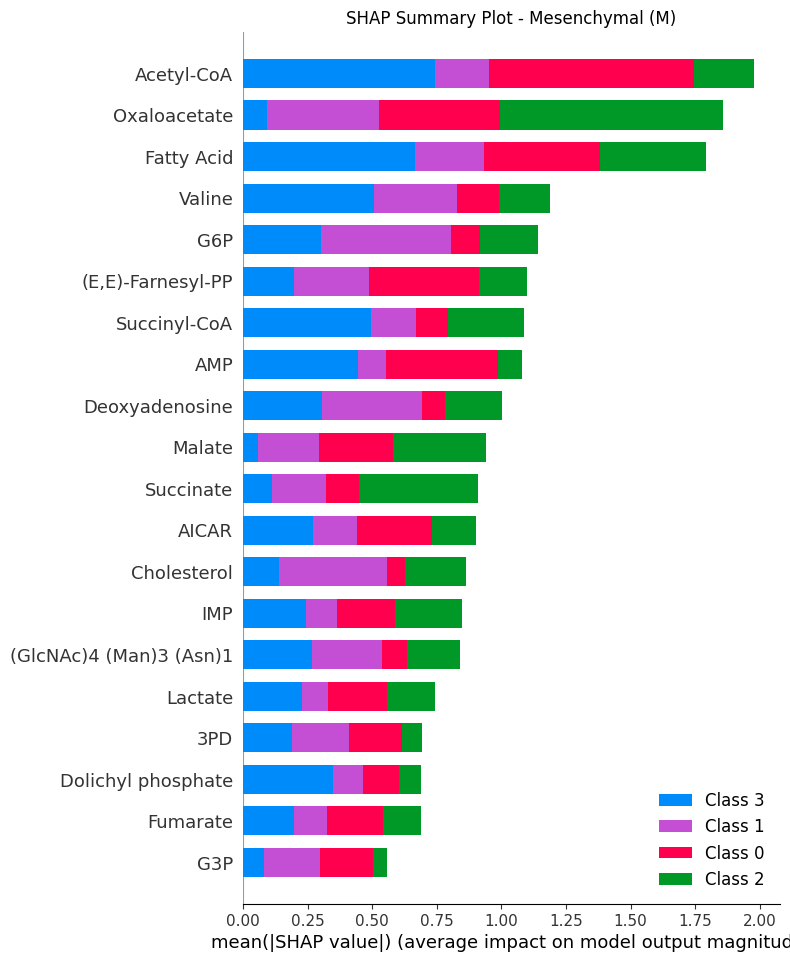

In [ ]:
# -------------------------
# SHAP Interpretability
# -------------------------
def model_predict(x_np):
    with torch.no_grad():
        return model(torch.tensor(x_np, dtype=torch.float)).numpy()

explainer = shap.Explainer(model_predict, X_train)
shap_values = explainer(X_test)

# Global SHAP plots
shap.summary_plot(shap_values, X_test, feature_names=feature_names)
shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_type="bar")

# Subtype-Specific SHAP
for idx, subtype in enumerate(label_encoder.classes_):
    subtype_indices = np.where(y_test == idx)[0]
    subtype_X = X_test[subtype_indices]
    subtype_shap_values = shap_values[subtype_indices]

    print(f"\nSHAP for Subtype: {subtype}")
    shap.summary_plot(subtype_shap_values, subtype_X, feature_names=feature_names, plot_type="bar", show=False)
    plt.title(f"SHAP Feature Importance - {subtype}")
    plt.show()

    shap.summary_plot(subtype_shap_values, subtype_X, feature_names=feature_names, show=False)
    plt.title(f"SHAP Summary Plot - {subtype}")
    plt.show()

##========== Load  Data ==========

In [ ]:
# # ======================= Load Data =======================

# df_metabolites = pd.read_csv("/content/drive/MyDrive/THESIS/metabolites_training.csv")


##========== Load and Prepare Data ==========

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/THESIS/metabolites_training.csv")

In [ ]:
# Encode target labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['TNBC_Subtype'])
X = df.drop(columns=['TNBC_Subtype']).values

# Convert to tensors
X_tensor = torch.tensor(X, dtype=torch.float)
y_tensor = torch.tensor(y, dtype=torch.long)

# Number of classes
num_classes = len(np.unique(y))
input_dim = X.shape[1]


##========== Improved Transformer Configuration ==========

In [ ]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dim, num_heads, num_layers, dropout):
        super(TransformerModel, self).__init__()

        # Input layer to transform input to model dimension
        self.input_layer = nn.Linear(input_dim, hidden_dim)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Classification head
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # Add an extra dimension for transformer input
        x = self.input_layer(x).unsqueeze(1)  # Shape: (batch_size, seq_len=1, hidden_dim)
        x = self.transformer(x)  # Shape: (batch_size, seq_len, hidden_dim)
        x = x[:, 0, :]  # Take the first token output
        output = self.classifier(x)
        return output


### ========== Added Hyperparameter Tuning ==========

In [ ]:
hidden_dim = 128
num_heads = 8
num_layers = 3
dropout = 0.2
learning_rate = 0.0005
batch_size = 64
epochs = 50

# Initialize Model and Optimizer
model = TransformerModel(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    dropout=dropout,
    num_classes=num_classes
)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()


## ========== Train Transformer Model ==========

In [ ]:
train_losses = []
train_accuracies = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    output = model(X_tensor)
    loss = criterion(output, y_tensor)

    loss.backward()
    optimizer.step()

    # Track loss and accuracy
    train_losses.append(loss.item())
    predictions = output.argmax(dim=1)
    acc = (predictions == y_tensor).float().mean().item()
    train_accuracies.append(acc)

    if epoch % 5 == 0:
        print(f"Epoch {epoch}/{epochs} - Loss: {loss.item():.4f}, Accuracy: {acc:.4f}")

# Final Accuracy
final_accuracy = (predictions == y_tensor).float().mean().item()
print(f"\nFinal Training Accuracy: {final_accuracy:.4f}")


Epoch 0/50 - Loss: 1.4485, Accuracy: 0.2296
Epoch 5/50 - Loss: 1.4071, Accuracy: 0.2325
Epoch 10/50 - Loss: 1.3756, Accuracy: 0.3386
Epoch 15/50 - Loss: 1.3653, Accuracy: 0.3822
Epoch 20/50 - Loss: 1.2832, Accuracy: 0.4281
Epoch 25/50 - Loss: 1.1451, Accuracy: 0.4715
Epoch 30/50 - Loss: 1.0952, Accuracy: 0.4801
Epoch 35/50 - Loss: 1.0739, Accuracy: 0.4954
Epoch 40/50 - Loss: 1.0530, Accuracy: 0.5091
Epoch 45/50 - Loss: 1.0293, Accuracy: 0.5188

Final Training Accuracy: 0.5302


## ========== Evaluate Model ==========

Test Accuracy: 0.9489

Classification Report:
                                 precision    recall  f1-score   support

             Basal-like 1 (BL1)       0.99      0.93      0.96      7179
             Basal-like 2 (BL2)       0.95      0.96      0.95      7475
Luminal Androgen Receptor (LAR)       0.98      0.92      0.95      9662
                Mesenchymal (M)       0.90      0.97      0.94     10960

                       accuracy                           0.95     35276
                      macro avg       0.95      0.95      0.95     35276
                   weighted avg       0.95      0.95      0.95     35276



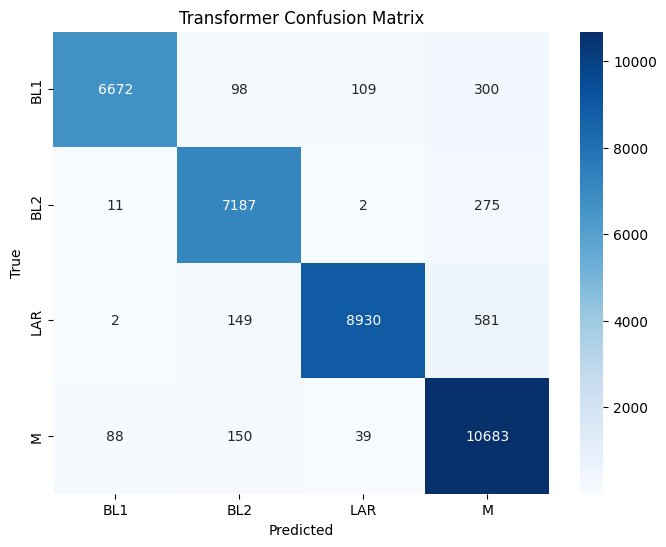


Matthews Correlation Coefficient (MCC): 0.9316


In [ ]:
model.eval()
with torch.no_grad():
    predictions = model(X_tensor).argmax(dim=1)

# Accuracy
accuracy = accuracy_score(y_tensor.cpu().numpy(), predictions.cpu().numpy())
print(f"Test Accuracy: {accuracy:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_tensor.cpu().numpy(), predictions.cpu().numpy(), target_names=label_encoder.classes_))

# Confusion Matrix


# Plot confusion matrix with proper formatting
cm = confusion_matrix(y_tensor.cpu().numpy(), predictions.cpu().numpy())
plt.figure(figsize=(8, 6))

# Modify the annot formatting
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["BL1", "BL2", "LAR", "M"], yticklabels=["BL1", "BL2", "LAR", "M"])
plt.title("Transformer Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(y_tensor.cpu().numpy(), predictions.cpu().numpy())
print(f"\nMatthews Correlation Coefficient (MCC): {mcc:.4f}")


## ========== ROC-AUC Curve ==========

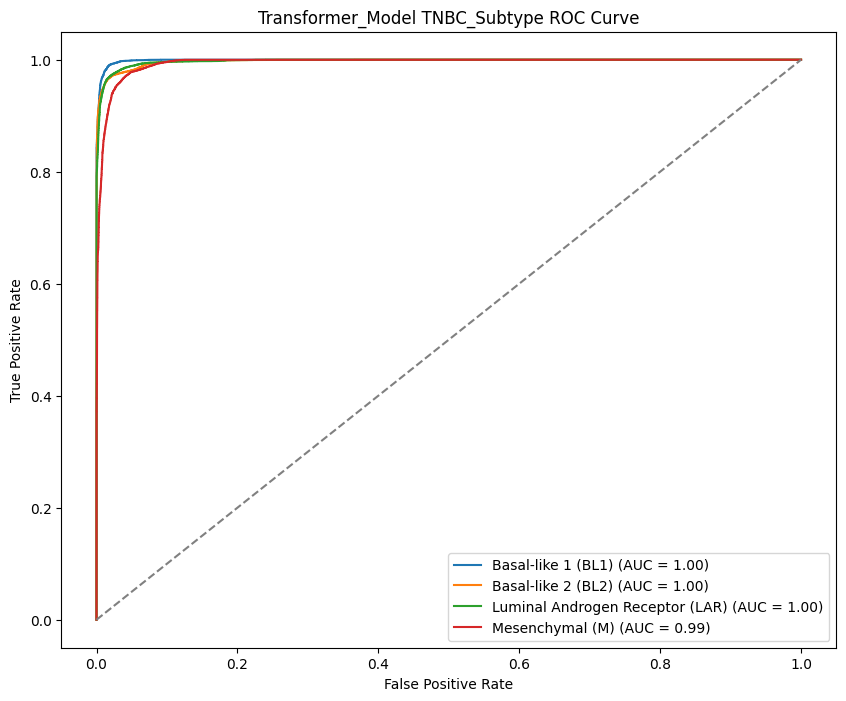

In [ ]:
y_true_bin = label_binarize(y_tensor.cpu().numpy(), classes=[0, 1, 2, 3])
y_proba = torch.softmax(model(X_tensor), dim=1).detach().cpu().numpy()

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label_encoder.classes_[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Transformer_Model TNBC_Subtype ROC Curve')
plt.legend()
plt.show()


## ========== Precision-Recall Curve ==========

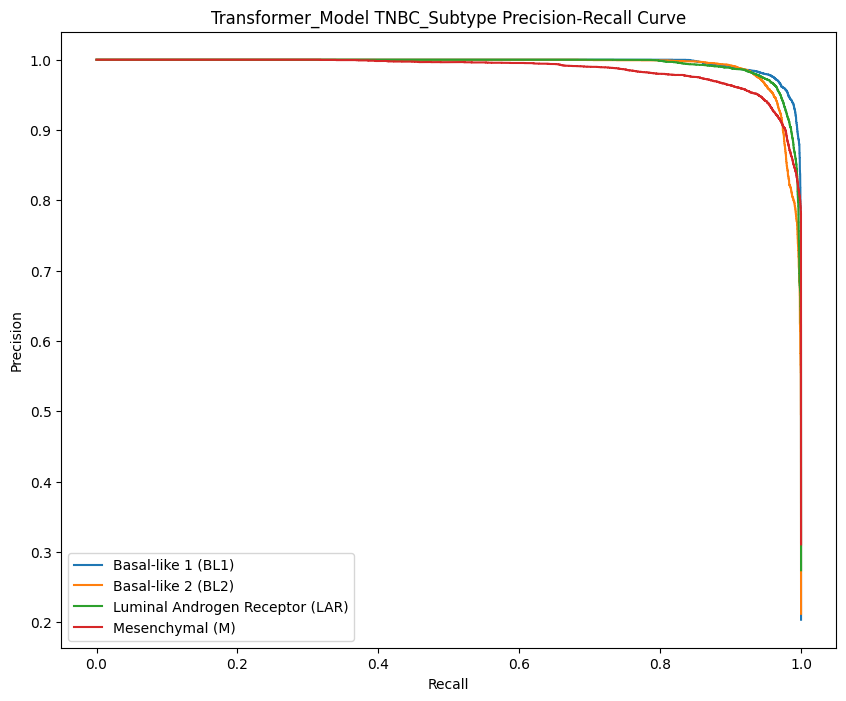

In [ ]:
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_proba[:, i])
    plt.plot(recall, precision, label=f'{label_encoder.classes_[i]}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Transformer_Model TNBC_Subtype Precision-Recall Curve')
plt.legend()
plt.show()


## ========== Plot Training Curves ==========

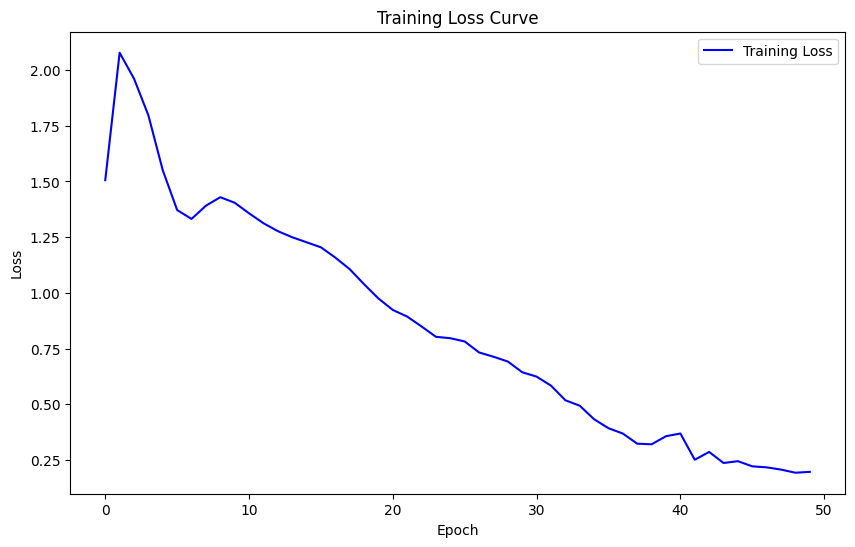

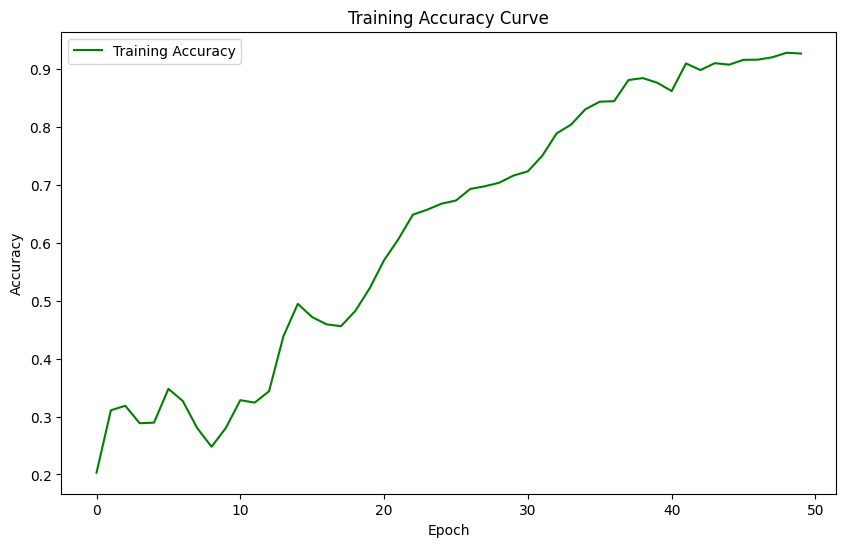

In [ ]:
# Loss Curve
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Training Loss", color="blue")
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Accuracy Curve
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label="Training Accuracy", color="green")
plt.title("Training Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


## ========== SHAP Explainability ==========

In [ ]:
X_numpy = X_tensor.cpu().numpy()

# Define a wrapper for SHAP
def model_wrapper(X):
    X_tensor = torch.tensor(X, dtype=torch.float).to(next(model.parameters()).device)
    return model(X_tensor).detach().cpu().numpy()

# Create SHAP Explainer
explainer = shap.Explainer(model_wrapper, X_numpy)
shap_values = explainer(X_numpy)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_numpy, feature_names=[f"Feature_{i+1}" for i in range(X_numpy.shape[1])])


ExactExplainer explainer:   0%|          | 38/35276 [07:55<117:17:28, 11.98s/it]

In [ ]:
## IMPORT LIBRARIES

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import precision_recall_curve

In [ ]:
### LOAD DATASET
# load Dataset and Inspect
df = pd.read_csv("/content/drive/MyDrive/MY THESIS/Thesis/metabolites_umap_training.csv")

In [ ]:
print(df.head())

     UMAP_1    UMAP_2     UMAP_3    UMAP_4    UMAP_5    UMAP_6    UMAP_7  \
0  8.241342  2.836038   9.341749  7.349958  1.117464  6.510367  0.701918   
1  9.322354  1.619440   9.282621  7.401401  0.608410  3.939373  0.593427   
2  6.595975  3.598134  10.037159  6.856321  0.965465  5.414550  1.544419   
3  7.943975  3.123704   9.244543  7.265599  1.277452  6.414673  0.720125   
4  8.081239  2.535117   9.423987  7.121435  0.857524  6.482847  0.633148   

     UMAP_8    UMAP_9   UMAP_10        TNBC_Subtype  
0  2.667602  8.374431  1.429310  Basal-like 2 (BL2)  
1  1.248321  8.376418  1.868097  Basal-like 1 (BL1)  
2  1.852219  8.402461  1.736903  Basal-like 2 (BL2)  
3  2.855604  8.410482  1.482119  Basal-like 2 (BL2)  
4  2.651115  7.995010  1.644847  Basal-like 2 (BL2)  


### Encode target labels and convert to tensors

In [ ]:
# Encode target labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['TNBC_Subtype'])
X = df.drop(columns=['TNBC_Subtype']).values

# Convert to tensors
X_tensor = torch.tensor(X, dtype=torch.float)
y_tensor = torch.tensor(y, dtype=torch.long)


### Define Transformer Model
- Transformer architecture with input layer, encoder, and classifier

In [ ]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dim, num_heads, num_layers, dropout):
        super(TransformerModel, self).__init__()

        self.input_layer = nn.Linear(input_dim, hidden_dim)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.input_layer(x).unsqueeze(1)  # Shape: (batch_size, seq_len=1, hidden_dim)
        x = self.transformer(x)  # Shape: (batch_size, seq_len, hidden_dim)
        x = x[:, 0, :]  # Take the first output position
        output = self.classifier(x)
        return output


 Initialize Model
- Set model parameters and optimizer

In [ ]:
input_dim = X.shape[1]
hidden_dim = 64
num_heads = 4
num_layers = 2
dropout = 0.1
num_classes = len(np.unique(y))

model = TransformerModel(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    dropout=dropout,
    num_classes=num_classes
)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


### Train the Transformer
- Training loop with loss and accuracy tracking

In [ ]:
epochs = 100
train_losses = []
train_accuracies = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    output = model(X_tensor)
    loss = criterion(output, y_tensor)

    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    predictions = output.argmax(dim=1)
    acc = (predictions == y_tensor).float().mean().item()
    train_accuracies.append(acc)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{epochs}, Loss: {loss.item():.4f}, Accuracy: {acc:.4f}")


Epoch 0/100, Loss: 1.5706, Accuracy: 0.3039
Epoch 10/100, Loss: 1.1912, Accuracy: 0.5314
Epoch 20/100, Loss: 0.5165, Accuracy: 0.8067
Epoch 30/100, Loss: 0.2496, Accuracy: 0.9135
Epoch 40/100, Loss: 0.1732, Accuracy: 0.9391
Epoch 50/100, Loss: 0.1389, Accuracy: 0.9512
Epoch 60/100, Loss: 0.1211, Accuracy: 0.9581
Epoch 70/100, Loss: 0.1116, Accuracy: 0.9588
Epoch 80/100, Loss: 0.1187, Accuracy: 0.9536
Epoch 90/100, Loss: 0.0953, Accuracy: 0.9647


Evaluate the Transformer
- Final accuracy and classification report

### Loss Accuracy Curve

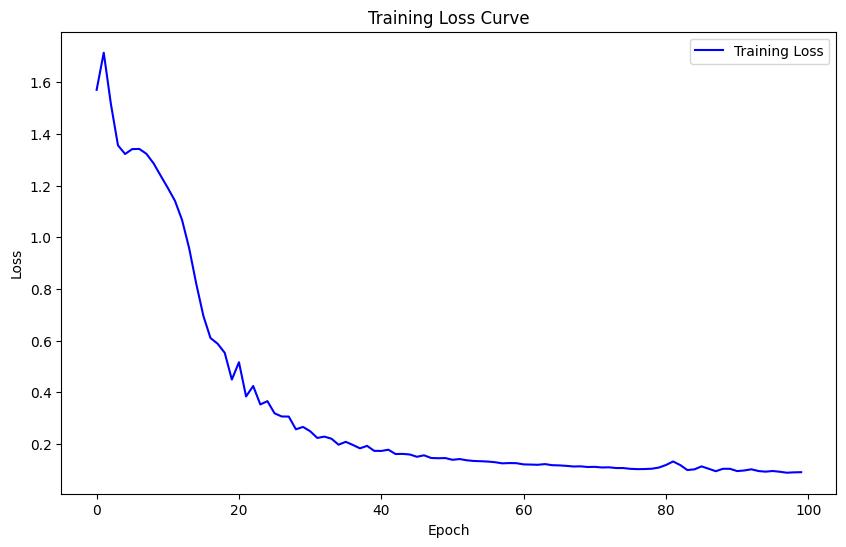

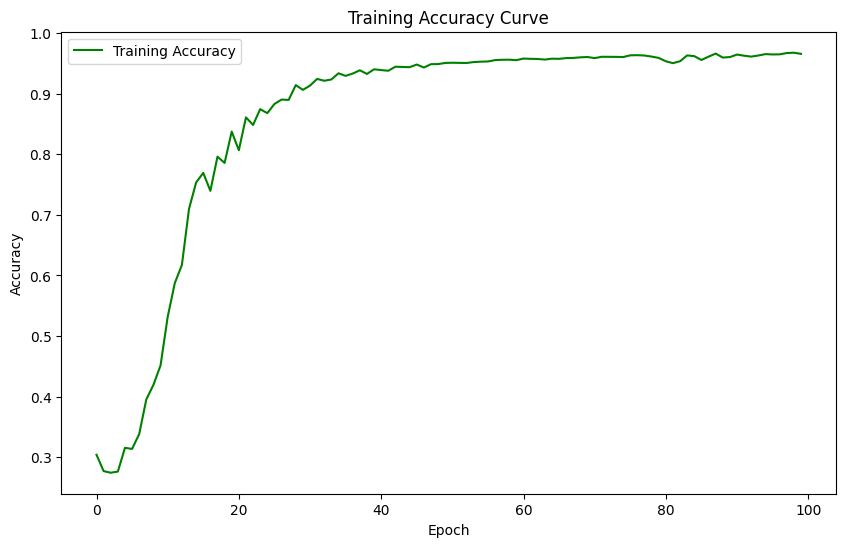

In [ ]:
# Loss Curve
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy Curve
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label='Training Accuracy', color='green')
plt.title('Training Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


#### Precision-Recall Curve
- Plot the precision-recall curve for each class

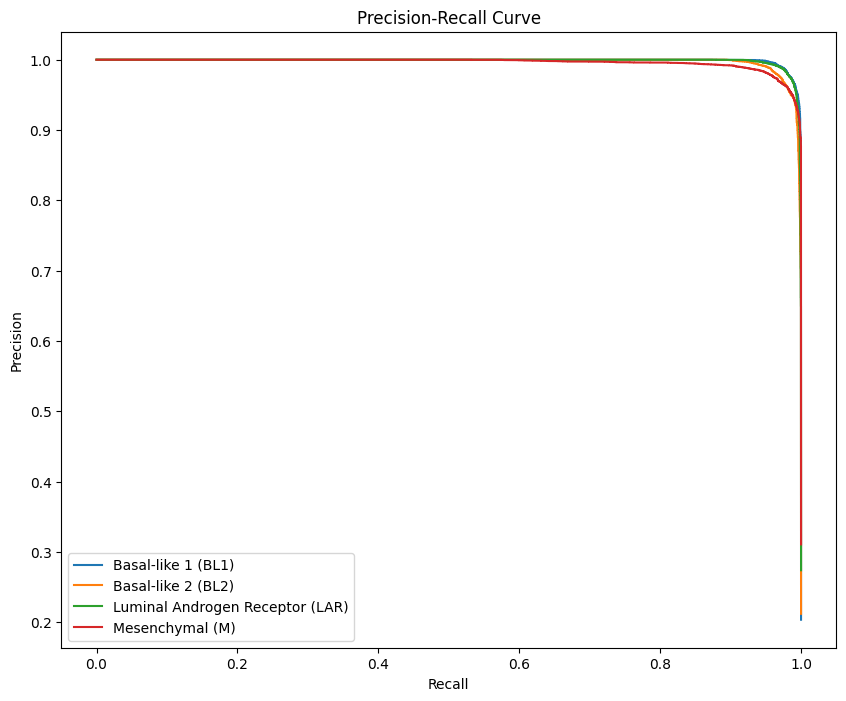

In [ ]:
# Get predicted probabilities and convert to numpy
y_proba = torch.softmax(model(X_tensor), dim=1).detach().cpu().numpy()
y_true_bin = np.eye(num_classes)[y_tensor.cpu().numpy()]

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_proba[:, i])
    plt.plot(recall, precision, label=f'{label_encoder.classes_[i]}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


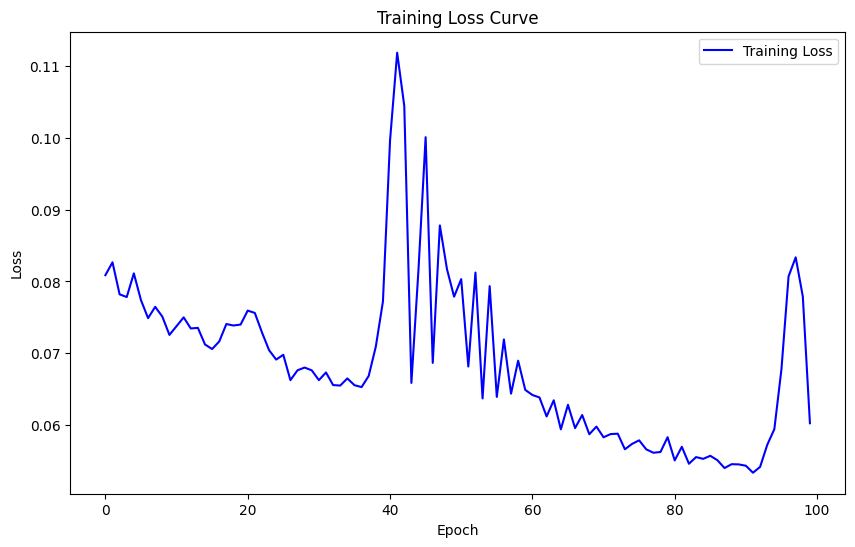

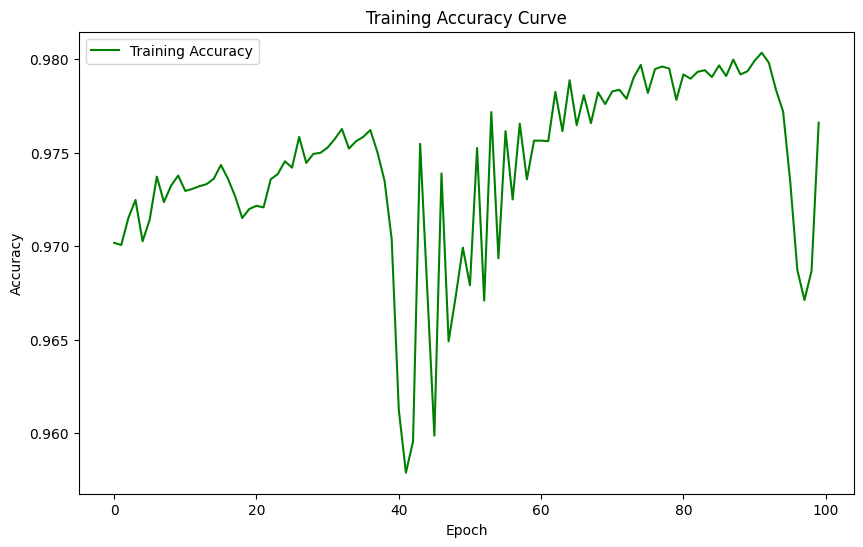

In [ ]:


# Loss Curve
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy Curve
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label='Training Accuracy', color='green')
plt.title('Training Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
print("\nClassification Report:")
print(classification_report(y_tensor.cpu().numpy(), predictions.cpu().numpy(), target_names=label_encoder.classes_))



Classification Report:
                                 precision    recall  f1-score   support

             Basal-like 1 (BL1)       0.97      0.99      0.98      7179
             Basal-like 2 (BL2)       0.98      0.98      0.98      7475
Luminal Androgen Receptor (LAR)       0.97      0.98      0.98      9662
                Mesenchymal (M)       0.99      0.96      0.97     10960

                       accuracy                           0.98     35276
                      macro avg       0.98      0.98      0.98     35276
                   weighted avg       0.98      0.98      0.98     35276



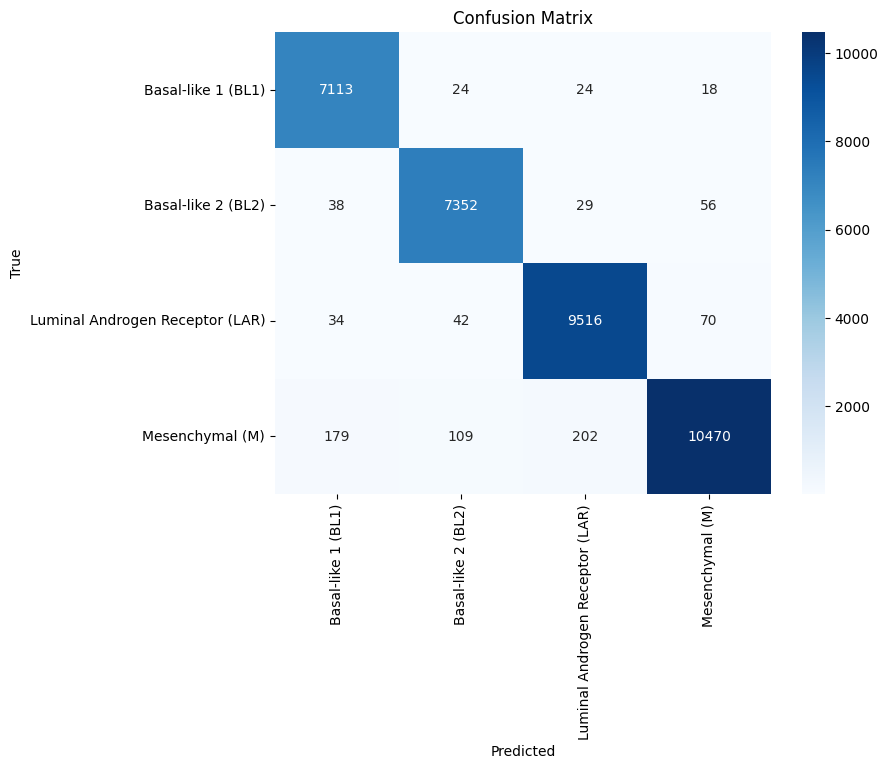

In [ ]:

cm = confusion_matrix(y_tensor.cpu().numpy(), predictions.cpu().numpy())
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt='d',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


### Plot ROC-AUC Curve

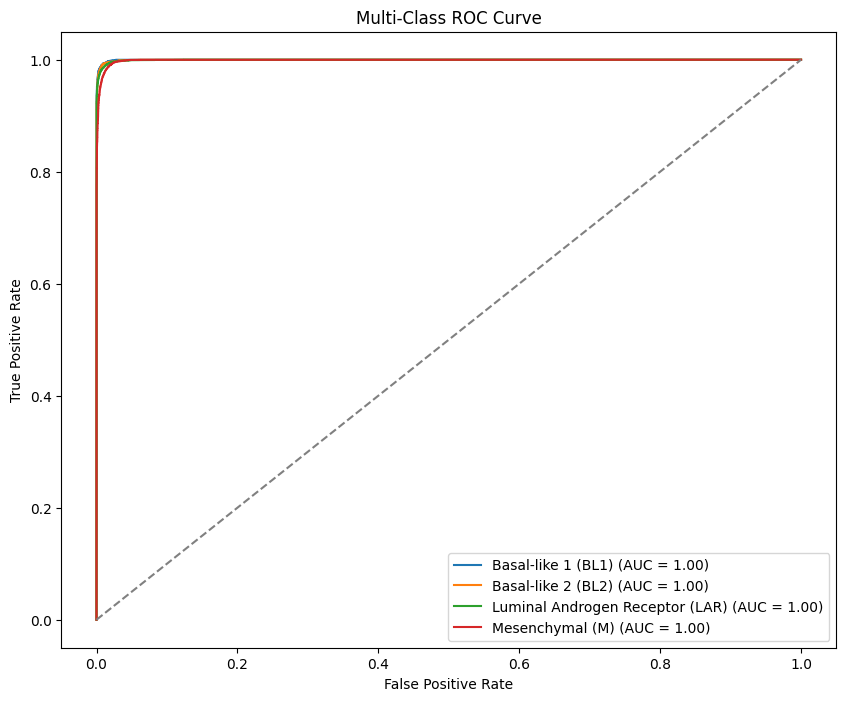

In [ ]:
y_true_bin = label_binarize(y_tensor.cpu().numpy(), classes=[0, 1, 2, 3])
y_proba = torch.softmax(model(X_tensor), dim=1).detach().cpu().numpy()
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label_encoder.classes_[i]} (AUC = {roc_auc:.2f})')

# Plot chance line
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend()
plt.show()


### Precision-Recall Curve

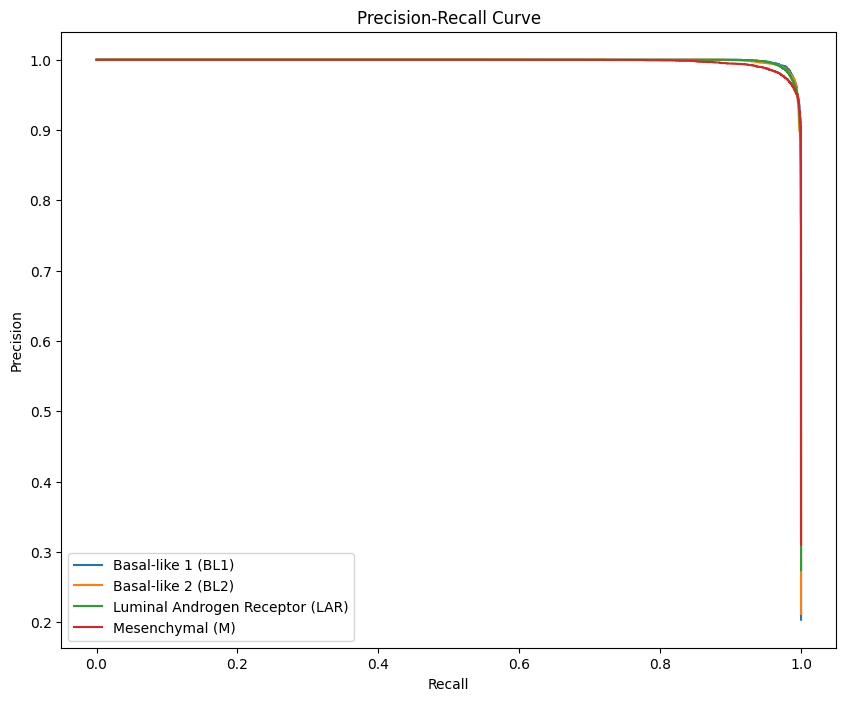

In [ ]:
from sklearn.metrics import precision_recall_curve

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_proba[:, i])
    plt.plot(recall, precision, label=f'{label_encoder.classes_[i]}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()
